In [22]:
import torch, torch.nn as nn, torch.nn.functional as F

In [36]:
torch.randn(2,10)[...,None].shape


torch.Size([2, 10, 1])

In [42]:
recon_loss_fn = lambda *args, **kwargs: torch.tensor(0., device=x.device)
recon_loss_fn('d', d=2)

tensor(0.)

In [183]:
class Halfer(nn.Module): # uses conv instead of avg_pool1d
    def __init__(self, dim):
        super().__init__()
        self.conv = nn.Conv1d(dim, dim*2, kernel_size=2, stride=2, padding=0, bias=True)
        self.act = nn.SiLU()
        self.ff = nn.Linear(dim*2, dim)

    def forward(self, x, length):
        if x.shape[1] % 2 == 1:
            x = torch.cat([x, torch.zeros_like(x[:,0:1,:])], dim=1)
            length += 1
        x = self.conv(x.transpose(1,2)).transpose(1,2)
        x = self.ff(self.act(x))
        length = (length + 1).div(2).floor().long()
        return x, length

class InverseHalfer(nn.Module): # opposite of Halfer
    def __init__(self, dim):
        super().__init__()
        self.conv = nn.ConvTranspose1d(dim, dim//2, kernel_size=2, stride=2, padding=0, bias=True)
        self.act = nn.SiLU()
        self.ff = nn.Linear(dim//2, dim)

    def forward(self, x, length):
        x = self.conv(x.transpose(1,2)).transpose(1,2)
        x = self.ff(self.act(x))
        length = length.mul(2)
        return x, length

class HalferBlock(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.halfer = Halfer(dim)
        self.inverse_halfer = InverseHalfer(dim)
        self.loss = nn.MSELoss(reduction='none')

    def forward(self, x, length, mask=None):
        halved_x, halved_length = self.halfer(x, length)
        loss = torch.tensor(0., device=x.device)
        if self.training:
            restored_x, restored_length = self.inverse_halfer(x, halved_length)
            restored_x = restored_x[:, :x.shape[1], :] # trim to original length
            loss = self.loss(restored_x, x)
            if mask is not None: # mask out padding
                loss.masked_fill_(mask, 0)
            loss = loss.mean()
        return halved_x, halved_length, loss


In [185]:
halfer = Halfer(256)
inv_halfer = InverseHalfer(256)
x = torch.randn(2, 100, 256)
length = torch.tensor([100, 65])
x, length = halfer(x, length)
print(x.shape, length)
x, length = inv_halfer(x, length)
print(x.shape, length)

torch.Size([2, 50, 256]) tensor([50, 33])
torch.Size([2, 100, 256]) tensor([100,  66])


In [34]:
a = torch.randn(3, 8, 32)
b = torch.randn(3, 8, 32)
mseloss = torch.nn.MSELoss(reduction='none')
loss = mseloss(a, b)
loss = loss.mean()
print(loss)

tensor(1.9711)


In [1]:
import matplotlib.pyplot as plt
import numpy as  np

In [1]:
import argparse
import pickle as pkl
from Levenshtein import distance
from speachy.rescoring.tools import ( sort_hypothesis_by_recording, order_recordings_by_start_time, )
import numpy as np
from functools import reduce
import torch
import os
import traceback
from speachy.utils.misc import ( add_common_args, get_parameters, load_pkl )

from speachy.utils.general import (
    load_config,
    load_checkpoint,
    load_tokenizer,
    save_checkpoint,
    save_schedular_data,
    write_to_log,
    draw_text,
)

from speachy.lm.tools.train import (
    loss_ce,
    batch_to_device,
    token_lens_to_mask,
    add_bos,
    add_eos,
    mark_padding
)

from speachy.utils.general import load_checkpoint
from speachy.lm.tools.loading import autoload
from speachy.utils.helpers import  exists, isfalse, istrue
from speachy.utils.general.training_loop import optimizer, update_schedular
from contextlib import nullcontext
from tqdm import tqdm
import wandb
from torch.cuda.amp import GradScaler   
from torch_ema import ExponentialMovingAverage

CUDA extension for cauchy multiplication not found. Install by going to extensions/cauchy/ and running `python setup.py install`. This should speed up end-to-end training by 10-50%
[NeMo W 2023-04-21 13:35:58 experimental:27] Module <class 'nemo.collections.nlp.data.language_modeling.megatron.megatron_batch_samplers.MegatronPretrainingRandomBatchSampler'> is experimental, not ready for production and is not fully supported. Use at your own risk.
[NeMo W 2023-04-21 13:35:58 experimental:27] Module <class 'nemo.collections.nlp.models.text_normalization_as_tagging.thutmose_tagger.ThutmoseTaggerModel'> is experimental, not ready for production and is not fully supported. Use at your own risk.


In [2]:
device, config = torch.device('cpu'), load_config('./experiment_configs/lm/uniformer_test.yaml')
tokenizer_path = os.path.join(config['model']['tokenizer']['dir'], 'tokenizer.model')
tokenizer = load_tokenizer(model_path=tokenizer_path)
model = autoload(config=config, tokenizer=tokenizer)
class argsclass:
    def __init__(self, **kwargs):
        self.__dict__.update(kwargs)
epoch_prev, val_loss = load_checkpoint(args=argsclass(**{'checkpoint':'./checkpoints/unitformer_test/checkpoint_7_id_46.pt'}), model=model, force_cpu=True)

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ /tmp/ipykernel_1998431/574941044.py:1 in <module>                                                │
│                                                                                                  │
│ [Errno 2] No such file or directory: '/tmp/ipykernel_1998431/574941044.py'                       │
│                                                                                                  │
│ /exp/exp1/acp21rjf/deliberation/speachy/speachy/utils/general/model_utils.py:12 in load_config   │
│                                                                                                  │
│    9 import json                                                                                 │
│   10                                                                                             │
│   11 def load_config(config:str):                                                                │
│ ❱ 12 │   return OmegaConf.load(config)                                                           │
│   13                                                                                             │
│   14 def write_to_log(log_file, data):                                                           │
│   15 │   if log_file is None or log_file == '':                                                  │
│                                                                                                  │
│ /store/store1/software/bin/anaconda3/envs/k2_custom-nemo/lib/python3.8/site-packages/omegaconf/o │
│ megaconf.py:183 in load                                                                          │
│                                                                                                  │
│    180 │   │   from ._utils import get_yaml_loader                                               │
│    181 │   │                                                                                     │
│    182 │   │   if isinstance(file_, (str, pathlib.Path)):                                        │
│ ❱  183 │   │   │   with io.open(os.path.abspath(file_), "r", encoding="utf-8") as f:             │
│    184 │   │   │   │   obj = yaml.load(f, Loader=get_yaml_loader())                              │
│    185 │   │   elif getattr(file_, "read", None):                                                │
│    186 │   │   │   obj = yaml.load(file_, Loader=get_yaml_loader())                              │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
FileNotFoundError: [Errno 2] No such file or directory: 
'/exp/exp1/acp21rjf/deliberation/speachy/ipynbs/experiment_configs/lm/uniformer_test.yaml'

In [4]:
import matplotlib.pyplot as plt

In [10]:
labels = tokenizer.text_to_ids('New Deep Learning Optimizer, Ranger: Synergistic combination of RAdam'.lower())
labels = torch.tensor(labels, device=device)[None]
labels = add_bos(labels, 0)
lengths = torch.tensor([len(labels[0])], device=device)
model.eval()
out = model(labels, lengths)

In [74]:
out['targets']

[tensor([[ 0,  1,  7,  2, 17,  1, 12,  2,  2, 20,  1, 11,  2,  4, 10,  7,  6,  7,
          18,  1,  5, 20,  3,  6, 16,  6, 27,  2, 10,  0,  1, 10,  4,  7, 18,  2,
          10,  0,  1,  8, 15,  7,  2, 10, 18,  6,  8,  3,  6, 14,  1, 14,  5, 16,
          21,  6,  7,  4,  3,  6,  5,  7,  1,  5, 19,  1, 10,  4, 12,  4, 16]]),
 tensor([[  1,  87,  83,  84, 112, 121, 112,  58,  79, 164,  22,  55,  55,  84,
            0,  93, 167,  94,   0, 173, 167, 166,  55, 135, 132,  21, 179,  55,
           23,  55,  38,  93, 133,  58,  23,  22]]),
 tensor([[226, 425, 239, 239, 239, 239, 239, 239, 239, 129, 129, 239, 239, 239,
          239, 239, 239, 239]]),
 tensor([[336, 336, 336, 336, 336, 336, 336, 336, 336]])]

In [72]:
tohighlight[0][5]

1

In [50]:
embedding[tohighlight[0][5], 0]

-10.652408

In [27]:
import vector_quantize_pytorch

In [ ]:
vector_quantize_pytorch.vector_quantize_pytorch_m.VectorQuantize

In [464]:
%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [22]:
import vector_quantize_pytorch

In [23]:
vector_quantize_pytorch.RandomProjectionQuantizer

vector_quantize_pytorch.random_projection_quantizer.RandomProjectionQuantizer

In [25]:
RandomProjectionQuantizer.prep

<function vector_quantize_pytorch.random_projection_quantizer.RandomProjectionQuantizer.prep(self, x)>

In [2]:
import torch, torch.nn as nn, torch.nn.functional as F
from speachy.lm.tools.train import add_eos, token_lens_to_mask, mark_padding
import numpy as np
from einops import rearrange, repeat
from torch import einsum
from torch.utils.checkpoint import checkpoint # # gradient/activation checkpointing
from functools import partial
import string
from math import ceil
from einops import einsum as einsumops
from vector_quantize_pytorch import RandomProjectionQuantizer
from vector_quantize_pytorch.vector_quantize_pytorch_m import VectorQuantize
from typing import Optional, Tuple, List, Dict, Union, Callable
import torch_scatter
import math

def exists(val):
    return val is not None

# token shifting
# lucidrains implementation: https://github.com/lucidrains/x-transformers/blob/main/x_transformers/x_transformers.py
# BlinkDL idea from RWKV-LM https://github.com/BlinkDL/RWKV-LM
def shift(t, amount, mask = None):
    if amount == 0:
        return t
    else:
        amount = min(amount, t.shape[1])

    if exists(mask):
        t = t.masked_fill(~mask[..., None], 0.)

    return F.pad(t, (0, 0, amount, -amount), value = 0.)

class ShiftTokens(nn.Module):
    '''from Phil Wang's x-transformers library'''
    def __init__(self, shifts, fn):
        super().__init__()
        self.fn = fn
        self.shifts = tuple(shifts)

    def forward(self, x, **kwargs):
        mask = kwargs.get('mask', None)
        shifts = self.shifts
        segments = len(shifts)
        feats_per_shift = x.shape[-1] // segments
        splitted = x.split(feats_per_shift, dim = -1)
        segments_to_shift, rest = splitted[:segments], splitted[segments:]
        segments_to_shift = list(map(lambda args: shift(*args, mask = mask), zip(segments_to_shift, shifts)))
        x = torch.cat((*segments_to_shift, *rest), dim = -1)
        return self.fn(x, **kwargs)

def ff(dim, mult=4, dropout=0.1):
    return nn.Sequential(
        GLU(dim, dim * mult, nn.SiLU()),
        nn.Dropout(dropout),
        nn.Linear(dim * mult, dim)
    )

class DynamicPositionBias(nn.Module):
    '''Adapted from Phil Wang's x-transformers library'''
    def __init__(self, dim, *, heads, depth, log_distance = False, norm = False, activation=nn.ReLU):
        super().__init__()
        assert depth >= 1, 'depth for dynamic position bias MLP must be greater or equal to 1'
        self.log_distance = log_distance

        self.mlp = nn.ModuleList([])

        self.mlp.append(nn.Sequential(
            nn.Linear(1, dim),
            nn.LayerNorm(dim) if norm else nn.Identity(),
            activation()
        ))

        for _ in range(depth - 1):
            self.mlp.append(nn.Sequential(
                nn.Linear(dim, dim),
                nn.LayerNorm(dim) if norm else nn.Identity(),
                activation()
            ))

        self.mlp.append(nn.Linear(dim, heads))


    def forward(self, pos, indices, device, dtype):
        pos = pos.to(device=device, dtype=dtype)
        
        if self.log_distance:
            pos = torch.sign(pos) * torch.log(pos.abs() + 1)  # log of distance is sign(rel_pos) * log(abs(rel_pos) + 1)

        for layer in self.mlp:
            pos = layer(pos) 
      
        bias = pos[indices]
        #print(bias.shape)
        bias = rearrange(bias, 'b i j h -> b h i j')
        return bias

class ScaledSinuEmbedding(nn.Module):
    '''taken From Phil Wang's x-transformers library'''
    def __init__(self, dim):
        super().__init__()
        self.scale = nn.Parameter(torch.ones(1,))
        inv_freq = 1. / (10000 ** (torch.arange(0, dim, 2).float() / dim))
        self.register_buffer('inv_freq', inv_freq)

    def forward(self, x):
        n, device = x.shape[1], x.device
        t = torch.arange(n, device = device).type_as(self.inv_freq)
        sinu = einsum('i , j -> i j', t, self.inv_freq)
        emb = torch.cat((sinu.sin(), sinu.cos()), dim = -1)
        return emb * self.scale

class ReLUSquared(nn.Module):
    def forward(self, x):
        return torch.pow(F.relu(x), 2)

def l2norm(t, groups = 1, dim = -1):
    if groups == 1:
        return F.normalize(t, p = 2, dim = dim)
    t = rearrange(t, '... (g d) -> ... g d', g = groups)
    t = F.normalize(t, p = 2, dim = dim)
    return rearrange(t, '... g d -> ... (g d)')



class Attention(nn.Module):
    def __init__(
        self,
        n_feats,
        head_dim,
        n_heads,
        dropout=0.1,
        bias=False,
        return_attention=False,
        causal=False,
        activation='softmax',
        **kwargs
    ):
        super().__init__()
        assert activation in ['relusq', 'softmax']
        self.shared_kv = kwargs.get('shared_kv', False)
        
        self.talking_heads = kwargs.get('talking_heads', 'none') # 'none', 'pre', 'both', 'post' 

        self.n_feats, self.head_dim, self.n_heads = n_feats, head_dim, n_heads
        self.dropout = nn.Dropout(dropout)
        self.bias = bias
        self.return_attention = return_attention
        self.causal = causal

        if self.talking_heads == 'pre' or self.talking_heads == 'both':
            self._head_proj = nn.Conv2d(n_heads, n_heads, (1, 1))
        if self.talking_heads == 'post' or self.talking_heads == 'both':
            self._head_proj_post = nn.Conv2d(n_heads, n_heads, (1, 1))
            

        self.activation = ReLUSquared() if activation == 'relusq' else nn.Softmax(dim=-1)

        if not self.shared_kv:
            self.qkv_proj = nn.Linear(n_feats, 3 * n_heads * head_dim, bias=bias)
            self.qkv = lambda x: rearrange(self.qkv_proj(x), "b n (h d qkv) -> qkv b h n d", qkv=3, h=n_heads, d=head_dim)
        else:
            self.q_proj, self.kv_proj = [nn.Linear(n_feats, el, bias=bias) for el in [n_heads * head_dim, 2 * head_dim]]
            map_q, map_kv = lambda q: rearrange(q, 'b n (h d) -> b h n d', h=n_heads), lambda kv: rearrange(kv, 'b n (kv d) -> kv b () n d', kv=2, d=head_dim)
            self.qkv = lambda x: (map_q(self.q_proj(x)), *map_kv(self.kv_proj(x)))

        self.out_proj = nn.Linear(n_heads * head_dim, n_feats, bias=bias)
    
    def head_proj(self, dots, mode='pre'):
        if mode == 'pre' and (self.talking_heads == 'pre' or self.talking_heads == 'both'):
            dots = self._head_proj(dots)
        if mode == 'post' and (self.talking_heads == 'post' or self.talking_heads == 'both'):
            dots = self._head_proj_post(dots)
        return dots      
  

    def attend(self, query, key, value, attn_mask, pos_bias):        
        dots = einsum('bhid,bhjd->bhij', query, key) * self.head_dim ** -0.5
        dots = self.head_proj(dots, mode='pre')

        dots += pos_bias
        dots.masked_fill_(attn_mask, -torch.finfo(dots.dtype).max)

        attn = self.activation(dots)
        attn = self.head_proj(attn, mode='post')
     
        attn = self.dropout(attn)
        return einsum("bhij,bhjd->bhid", attn, value)

    @staticmethod
    def attach_cache(kv, cache, cache_indices):
        kv = torch.stack(kv, dim=0)
        if cache is None:
            return kv
        zero_vector = torch.zeros_like(kv[:, :, :, :1, :])
        kv_w_cache = torch.cat([cache, kv, zero_vector], dim=-2)
        kv_w_cache = torch.gather(kv_w_cache, dim=-2, index=cache_indices) # we do this to remove unnecessary padding
        return kv_w_cache

    def forward(self, x, pos_bias, mask, cache=None, cache_indices=None):
        B, N, C, H, D = *x.shape, self.n_heads, self.head_dim
    
        q, k, v  = self.qkv(x)
        kv = self.attach_cache([k, v], cache, cache_indices)
        k, v = kv

        out = self.attend(q, k, v, mask, pos_bias)

        out = rearrange(out, "b h n d -> b n (h d)")
        out = self.out_proj(out)
        return out, kv

class PreNorm(nn.Module):
    def __init__(self, dim, fn, elementwise_affine=True):
        super().__init__()
        self.norm = nn.LayerNorm(dim, elementwise_affine=elementwise_affine)
        self.fn = fn

    def forward(self, x, *args, **kwargs):
        return self.fn(self.norm(x), *args, **kwargs)

class NoGrad(nn.Module):
    def __init__(self, fn):
        super().__init__()
        self.fn = fn

    @torch.no_grad()
    def forward(self, *args, **kwargs):
        return self.fn(*args, **kwargs)

class GLU(nn.Module):
    def __init__(self, dim_in, dim_out, activation):
        super().__init__()
        self.act = activation
        self.proj = nn.Linear(dim_in, dim_out * 2)

    def forward(self, x):
        x, gate = self.proj(x).chunk(2, dim = -1)
        return x * self.act(gate)

def orthogonal_loss_fn(t):
    # eq (2) from https://arxiv.org/abs/2112.00384
    h, n = t.shape[:2]
    normed_codes = l2norm(t)
    cosine_sim = einsum('h i d, h j d -> h i j', normed_codes, normed_codes)
    return (cosine_sim ** 2).sum() / (h * n ** 2) - (1 / n)



class orthoginal_loss(nn.Module): # same as above but as a module
    def __init__(self, weight=1.0):
        super().__init__()
        self.loss_fn = orthogonal_loss_fn_padded
        self.weight = weight

    def forward(self, t, mask=None):
        return self.loss_fn(t, mask) * self.weight

class Halfer(nn.Module): # uses conv instead of avg_pool1d
    def __init__(self, dim, exp_f=4):
        super().__init__()
        self.conv = nn.Conv1d(dim, dim*exp_f*2, kernel_size=2, stride=2, padding=0, bias=True)
        self.act = nn.SiLU()
        self.empty_vec = torch.zeros(1,1,dim)
        self.ff = nn.Linear(dim*exp_f, dim)

    def forward(self, x, length):
        if x.shape[1] % 2 == 1:
            x = torch.cat([x, self.empty_vec.to(x.device).expand(x.shape[0],1,-1)], dim=1)
            length += 1
        x = self.conv(x.transpose(1,2)).transpose(1,2)
        a, b = x.chunk(2, dim=-1)
        x = a * self.act(b)
        x = self.ff(x)
        length = (length + 1).div(2).floor().long()
        return x, length

class InverseHalfer(nn.Module): # opposite of Halfer
    def __init__(self, dim, exp_f=2):
        super().__init__()
        self.conv = nn.ConvTranspose1d(dim, dim*exp_f, kernel_size=2, stride=2, padding=0, bias=True)
        self.act = nn.SiLU()
        self.ff = nn.Linear(dim*exp_f, dim)

    def forward(self, x, length):
        x = self.conv(x.transpose(1,2)).transpose(1,2)
        x = self.ff(self.act(x))
        length = length.mul(2)
        return x, length

class HalferBlock(nn.Module):
    def __init__(self, dim, exp_f=2):
        super().__init__()
        self.halfer = PreNorm(dim=dim, fn=Halfer(dim, exp_f=exp_f))
        self.inverse_halfer = PreNorm(dim=dim, fn=InverseHalfer(dim, exp_f=exp_f))
        self.loss = nn.MSELoss(reduction='none')

    def forward(self, x, length, mask=None):
        halved_x, halved_length = self.halfer(x, length)
        def recon_loss_fn(quantized_x):
            restored_x, _ = self.inverse_halfer(quantized_x, halved_length)
            restored_x = restored_x[:, :x.shape[1], :] # trim to original length
            loss = torch.tensor([0.], device=x.device)
            if self.training:
                loss = self.loss(restored_x, x)
                if mask is not None: # mask out padding
                    loss.masked_fill_(mask[..., None], 0.)
                loss = loss.mean()
            return loss, restored_x
        return halved_x, halved_length, recon_loss_fn



class PredictionLayer(nn.Module):
    def __init__(self, dim, n_classes):
        super().__init__()
        self.proj = PreNorm(dim, nn.Linear(dim, n_classes))
    def forward(self, x):
        return self.proj(x)



def grab_last_token(x, length):
    return x[torch.arange(x.shape[0]), length-1][:,None,:]

class AttentionFF(nn.Module):
    def __init__(
            self, 
            dim, 
            n_heads, 
            head_dim, 
            dropout=0., 
            ff_mult=4,
            causal=True,
            **kwargs
        ):
        super().__init__()
        self.attention = Attention(dim, n_heads=n_heads, head_dim=head_dim, causal=causal,dropout=dropout,**kwargs)
        self.ff = ff(dim, mult=ff_mult, dropout=0.1)
        self.ff, self.attention = map(PreNorm, (dim, dim), (self.ff, self.attention))

    def forward(self, x, pos_bias, attn_mask, cache=None, cache_indices=None):
        x_out, kv = self.attention(x, pos_bias, attn_mask, cache, cache_indices)
        x = x_out + x
        x = self.ff(x) + x
        return x, kv


class AttentionFFstack(nn.Module):
    def __init__(
        self,
        dim=256, 
        total_depth=3,
        n_heads=8, 
        head_dim=32, 
        dropout=0., 
        ff_mult=4,
        causal=True,
        **kwargs
    ):   
        super().__init__()
        self.layers = nn.ModuleList([])
        for _ in range(total_depth):
            self.layers.append(AttentionFF(dim, n_heads, head_dim, dropout, ff_mult, causal, **kwargs))

    def forward(self, x, pos_bias, attn_mask, cache=None, cache_indices=None):
        cached_kvs = []
        for i, layer in enumerate(self.layers):
            x, kv = layer(x, pos_bias, attn_mask, cache[i] if cache is not None else None, cache_indices)
            cached_kvs.append(kv[None])
        return x, cached_kvs

def map_to_sequence(int_list):
    unique_ints = torch.unique(int_list)
    max_int = unique_ints.max()
    seq = torch.zeros(max_int + 1, dtype=torch.int64)
    seq[unique_ints] = torch.arange(len(unique_ints))
    return seq[int_list]


class EinopsFn(nn.Module):
    def __init__(self):
        super().__init__()
    def forward(self, x, y, pattern):
        return einsumops(x, y, pattern)

def stable_weighted_softmax(logits, weights):
    ## logits: B, H, N, V # weights: 1 H 1 V ##
    stable_logits = logits - logits.max(dim=-1, keepdim=True)[0] # subtract max to make logits more stable
    weights = weights.clamp(min=torch.finfo(weights.dtype).eps)
    numerators = torch.exp(stable_logits) * weights
    denominators = numerators.sum(dim=-1, keepdim=True) 
    return numerators / (denominators + torch.finfo(denominators.dtype).eps)
    
class StableWeightedSoftmax(nn.Module):
    def __init__(self):
        super().__init__()
    def forward(self, logits, weights):
        return stable_weighted_softmax(logits, weights)

class transformer(nn.Module):
    def __init__(
            self, 
            dim, 
            depth, 
            heads, 
            dim_head, 
            causal=True,
            base_vocab_size=29,
            dropout = 0.1,
            **kwargs
        ):
        super().__init__()
    

        ff_mult = kwargs.get('ff_mult', 4)
        self.checkpoint_every_n = kwargs.get('checkpoint_every_n', 0)
        self.base_vocab = base_vocab_size
        self.max_vocab = kwargs.get('max_vocab', 10000)
        commitment_weight = kwargs.get('commitment_weight', 1.0)
        self.inner_depth = kwargs.get('inner_depth', 2)

        self.embedding = nn.Embedding(base_vocab_size, dim)

        self.causal = causal

        self.depth = depth
        self.positional_bias = DynamicPositionBias(
            dim = dim // 4,
            heads = heads,
            depth = 2,
            log_distance = False,
            norm = False
        )

        self.halfers = nn.ModuleList([])

        self.codebook_dim = 8
        self.codebook_heads = 8
        self.codebook_vocab = 1024
        
        self.vqs = nn.ModuleList([])
            
        self.prediction_layers = nn.ModuleList([])

        self.attn_ffs = nn.ModuleList([])
        for lth in range(depth):
            self.attn_ffs.append(AttentionFFstack(
                total_depth=self.inner_depth,
                dim=dim,
                n_heads=heads,
                head_dim=dim_head,
                causal=causal,
                dropout=dropout,
                **kwargs
            ))

            if lth == 0:
                self.prediction_layers.append(PredictionLayer(dim, base_vocab_size))
            else:
                self.prediction_layers.append(PredictionLayer(dim, self.codebook_vocab*self.codebook_heads))

            if lth < depth - 1:
                '''self.vqs.append(
                    RandomProjectionQuantizer(
                        dim = dim,
                        codebook_dim = self.codebook_dim,
                        codebook_size = self.codebook_vocab,
                        num_codebooks = self.codebook_heads,    
                    )
                )
                '''
                self.vqs.append(
                    VectorQuantize(
                        dim=dim,
                        codebook_size=self.codebook_vocab,
                        codebook_dim = self.codebook_dim,
                        use_cosine_sim = True,
                        decay = 0.9999,
                        separate_codebook_per_head=True,
                        heads=self.codebook_heads,
                        threshold_ema_dead_code=0.01,
                    )
                )
                self.vqs[-1].requires_grad_(False)
                self.halfers.append(PreNorm(dim=dim, fn=Halfer(dim, exp_f=8), elementwise_affine = True))
                self.halfers[-1].fn.requires_grad_(False)

        self.einopsfn = EinopsFn()



    @staticmethod
    def create_custom_forward(module):
        def custom_forward(*args, **kwargs):
            return module(*args, **kwargs)
        return custom_forward

    def checkpoint(self, layer, module, *args, **kwargs):
        condition = self.training and self.checkpoint_every_n != 0 and layer < self.depth - 1 and layer % self.checkpoint_every_n == 0
        return checkpoint(self.create_custom_forward(module), *args, **kwargs) if condition else module(*args, **kwargs)

    @staticmethod
    def get_cache(cache):
        if cache is None:
            return None
        return cache['cache'][0]

    @staticmethod
    def get_cache_indices(x_lens, cache_lens, cache_kv, x):  
        # used later w/ gather to remove padding when cache is concatenated with current input to remove padding
        max_new_len = (x_lens + cache_lens).max()
        # cache kv =  LAYERS, KEYS+VALUES (2), BATCH, HEADS, N, DIM
        B, H, N, D = x.shape[0], cache_kv.shape[-3], (x.shape[1] + cache_kv.shape[-2]), cache_kv.shape[-1]
        indices = []
        for i in range(B): # stinky for loop to sort out indices for gather 
            cache_indices = torch.arange(cache_lens[i], device='cpu')
            total_length = cache_lens[i] + x_lens[i] 
            diff_from_max_len = max_new_len - total_length
            x_indices = torch.arange(x_lens[i]+diff_from_max_len, device='cpu') + cache_kv.shape[-2]
            if diff_from_max_len > 0:
                x_indices[-diff_from_max_len:] = N  # last index will be used for padding
            new_indices = torch.cat([cache_indices, x_indices])
            indices.append(new_indices)

        indices = torch.stack(indices, dim=0)
        
        indices = rearrange(indices, 'b n -> () b () n ()').expand(2, B, H,-1, D) # 2 for key and value
        return indices.to(x.device)

    def create_masks_and_positions(self, x, length, cache): 
        x_len = length if length is not None else torch.tensor(x.shape[-2]).expand(x.shape[0])
        cache_len = cache['cache_lengths'] if exists(cache) else 0

        total_len = x_len + cache_len
        kv_mask = torch.arange(total_len.max(), device=x.device).expand(len(total_len), -1) >= total_len.unsqueeze(-1)
        q_mask = torch.arange(x_len.max(), device=x.device).expand(len(x_len), -1) >= x_len.unsqueeze(-1)
        attn_mask = ~(rearrange(~q_mask, "b n -> b () n ()") * rearrange(~kv_mask, "b n -> b () () n"))
        ##
        ##
        causal_mask = repeat(torch.arange(total_len.max(), device=x.device), 'i -> b r i', b=len(total_len), r=x_len.max())
        cache_offset = cache_len[:,None,None] if exists(cache) else cache_len
        diagonal_offset = torch.arange(x_len.max(), device=x.device)[None,:,None]
        ##
        ## positional stuff ##
        positional_grid = (causal_mask - cache_offset - diagonal_offset) * -1
        pos = torch.arange(positional_grid.min(), positional_grid.max()+1, device=x.device, dtype=x.dtype)[:,None]
        min_cache_len = 0 if cache_len.__class__ == int else cache_len.min()
        positional_indices = ((positional_grid) + (total_len.max() - min_cache_len - 1)) # shift so zero is the smallest number
        pos_bias = self.positional_bias(pos=pos, indices=positional_indices, dtype=x.dtype, device=x.device)
        ## positional stuff ##
        ##
        if self.causal:
            causal_mask = causal_mask >= (cache_offset + diagonal_offset + 1)
            attn_mask = torch.logical_or(attn_mask, causal_mask[:,None])
        ##
        return q_mask, attn_mask, total_len, x_len, cache_len, pos_bias


    def next_token_mse_loss(self, x, y, length):
        '''minimise MSE between each x_t and y_t+1'''
        B,N,D = x.shape
        y = y[:,1:].clone()
        x = x[:,:-1].clone()
        # mask that is shifted for next token prediction
        mask = torch.arange(N-1, device=x.device).expand(B,-1) >= length[:,None] -2 # -2 bcos -1 for N-1 arange and -1 for shifted mask
        x = l2norm(x, groups=8)
        y = l2norm(y, groups=8)
        loss = self.checkpoint(0, self.einopsfn, x, y, 'b n d, b n d -> b n')
        loss = (-1) * loss # maximise similarity
        loss = loss + 8 # shift so that loss is positive (number of groups)
        
        loss = loss.masked_fill(mask, 0)
        loss = loss.sum() / (~mask).sum()
        if torch.isnan(loss): # empty sequence
            loss = torch.tensor(0, device=x.device, dtype=x.dtype)
        return loss 



    def forward(self, x, length, cache=None, **kwargs):
        
        intermediate_logits = []
        next_token_preds = []
        
        intermediate_targets = [None] # for the first layer we use ground truth tokens as targets
        cache_lengths = []
        lengths = [length.clone()]
        cached_kvs = []
        x_outs = []

 
        curcache = cache[0] if exists(cache) else None
        mask, attn_mask, total_lens, x_len, cache_len, pos_bias = self.create_masks_and_positions(x, length, curcache)
        cache_indices = self.get_cache_indices(x_len, cache_len, curcache['cache'], x) if exists(curcache) else None

        mask, attn_mask, total_lens, x_len, cache_len, pos_bias = self.create_masks_and_positions(x, length, curcache)
        cache_indices = self.get_cache_indices(x_len, cache_len, curcache['cache'], x) if exists(curcache) else None

        all_ema_data = []

        pred_layers, hidden_outs, post_project_fn = [], [], []

        for i in range(self.depth):
            attn_ff, pred_layer = self.attn_ffs[i], self.prediction_layers[i]

            ## attention ff blocks ##
            
            attn_cache = [cache[ix]['cache'][0] if exists(cache) else None for ix in range(i*self.inner_depth, i*self.inner_depth+self.inner_depth)] 
            x, kvs = self.checkpoint(i, attn_ff, x, pos_bias, attn_mask, attn_cache, cache_indices)
    
            cached_kvs.extend(kvs)
            cache_lengths.extend([total_lens]*len(kvs))
            ## attention ff blocks ##

            pred_layers.append(pred_layer)
            hidden_outs.append(x)
            if i != 0:
                post_project_fn.append(lambda el: rearrange(el, 'b n (h v) -> b h n v', h=self.codebook_heads))
            else:
                post_project_fn.append(lambda el: el)

            if i != self.depth-1:
                halfer = self.halfers[i]
                x, length = self.checkpoint(i, halfer, x, length)
                x_outs.append(x)
                xbelow = x.clone()
                lengths.append(length.clone())
                
                
                curcache = cache[(i+1)*self.inner_depth] if exists(cache) else None
                mask, attn_mask, total_lens, x_len, cache_len, pos_bias = self.create_masks_and_positions(x, length, curcache)
                cache_indices = self.get_cache_indices(x_len, cache_len, curcache['cache'], x) if exists(curcache) else None


                B, N, D = x.shape
                vq = self.vqs[i]
                _,indices,_, ema_data = self.checkpoint(i, vq, x)

                if self.training:
                    all_ema_data.append(ema_data)

                if len(indices.shape) == 2:
                    indices = rearrange(indices, 'b n -> b n ()') # add dummy head dimension

                intermediate_targets.append(indices)

        #orth_loss = orthogonal_loss_fn(pred_matrix)
        #commitment_loss =  orth_loss.sum() * 10.0 

        for pix in range(len(pred_layers)): # compute next token predictions
            zsim = self.checkpoint(pix, pred_layers[pix], hidden_outs[pix])
            zsim = post_project_fn[pix](zsim)
            clen = lengths[pix]
            if pix != 0:
                clen = repeat(clen, 'b -> (b h)', h=self.codebook_heads)
                zsim = rearrange(zsim, 'b h n v -> (b h) n v')
            ntp = grab_last_token(zsim, clen)
            if pix != 0:
                ntp = rearrange(ntp, '(b h) n v -> b h n v', h=self.codebook_heads)
                zsim = rearrange(zsim, '(b h) n v -> b h n v', h=self.codebook_heads)
            intermediate_logits.append(zsim)
            next_token_preds.append(ntp)

        #print(len(cached_kvs), len(layer_below_next_token_preds), len(cache_lengths), len(next_token_preds))
        assert len(cached_kvs) == len(cache_lengths), 'something went wrong'
  
        cached_kvs = [{'cache': curcache, 'cache_lengths': curlen} for curcache, curlen in zip(cached_kvs, cache_lengths)]
        cached_kvs = {'layers': cached_kvs, 'next_sentence_pred': next_token_preds}
        '''# shift layers down list down by 1 
        print(len(cached_kvs['layers']))
        cached_kvs['layers'] = cached_kvs['layers'][self.inner_depth:] + [cached_kvs['layers'][-1]]*self.inner_depth
        print(len(cached_kvs['layers']))'''

        
        return {
            'logits': intermediate_logits,
            'targets': intermediate_targets,
            'cache': cached_kvs,
            'lengths': torch.stack(lengths),
            'x_outs': x_outs,
            'all_ema_data': all_ema_data,
            'hidden_outs': hidden_outs,
        }


class transformer_lm(nn.Module):
    def __init__(
        self,
        dim,
        vocab_size,
        depth,
        heads,
        dim_head,
        causal=True,
        dropout=0.,
        use_abs_pos=False,
        **kwargs
    ):
        super().__init__()
    
        self.use_abs_pos = use_abs_pos
        if self.use_abs_pos:
            self.abs_pos_fn = ScaledSinuEmbedding(dim=dim)
        self.abs_pos = lambda x: x + self.abs_pos_fn(x) if self.use_abs_pos else x


        self.layers = transformer(
            dim = dim, 
            depth = depth, 
            heads = heads, 
            dim_head = dim_head, 
            causal = causal, 
            dropout = dropout,
            base_vocab_size = vocab_size,
            **kwargs
        )
        

    def count_parameters(self):
        return sum(p.numel() for p in self.parameters() if p.requires_grad)

   
    def calc_all_losses(self, tlm_out, prev_cache):
        eos_id = -100
        loss_fn = lambda l, t: F.cross_entropy(rearrange(l, 'b n c -> b c n'), t, ignore_index=-100, reduction='mean')
        losses = []

        def calc_token_loss(logits, targets, first_token_pred, length):
            if length.max() == 1 and not exists(first_token_pred):
                return None # no loss for single token sequences if no previous prediction is available
            heads = 1
            if len(logits.shape) == 4:
                heads = logits.shape[1]
                length = repeat(length, 'b -> (b h)', h=heads).clone().contiguous()
                logits = rearrange(logits, 'b h n v -> (b h) n v')
                targets = rearrange(targets, 'b n (h 1) -> (b h) n')
                first_token_pred = None if not exists(first_token_pred) else rearrange(first_token_pred, 'b h n v -> (b h) n v')

            if exists(first_token_pred): # concat zero vect to end of targets
                targets = rearrange(targets, '(b h) n -> b h n', h=heads)
                targets = torch.cat([targets, torch.zeros(targets.size(0), heads, 1, device=targets.device).long()], dim=2)
                targets = rearrange(targets, 'b h n -> (b h) n')
                logits = torch.cat([first_token_pred, logits], dim=1)
                length += 1
            else:
                if heads == 1:
                    targets[:,:-1] = targets.clone()[:,1:]
                else:
                    targets = rearrange(targets, '(b h) n -> b h n', h=heads)
                    targets[:,:,:-1] = targets.clone()[:,:,1:]
                    targets = rearrange(targets, 'b h n -> (b h) n')
            
            targets = add_eos(targets, eos_id=eos_id, token_lens=length)
            mask =  token_lens_to_mask(token_lens=length)
            
            targets = mark_padding(targets=targets, mask=mask, pad_id=eos_id)
            loss = loss_fn(logits, targets) #* heads # multiply by heads 
            
            return loss

    
        if exists(prev_cache):
            assert len(tlm_out['logits']) == len(prev_cache['next_sentence_pred']), 'something went wrong'
        for lth in range(len(tlm_out['logits'])):
            logits = tlm_out['logits'][lth]
            targets = tlm_out['targets'][lth]
            
            #print(targets.reshape(-1).unique().shape)
            first_token_pred = prev_cache['next_sentence_pred'][lth] if exists(prev_cache) else None
            
            lengths = tlm_out['lengths'][lth]
            loss = calc_token_loss(logits, targets.clone(), first_token_pred, lengths.clone())
            if exists(loss): # incase of single token sequences
                losses.append(loss)
              
        tlm_out['token_losses'] = torch.stack(losses) 

        return tlm_out

    def forward(self, labels, length, cache:Dict=None, calc_loss=False, **kwargs):
        '''
        x: [B, N] (embedding indices)
        length: [B] (length of each sequence)
        cache: {cache_lengths: [B, N], cache: [L, KV, B, H, N, D]} KV: key and value (2)
        '''
        assert labels.shape[1] == length.max(), 'sequence length should be equal to the length of the longest sequence!'
        x = self.layers.embedding(labels)
        x = self.abs_pos(x) 
        
        outputs = self.layers(x, length, cache=cache['layers'] if exists(cache) else None, **kwargs)

        if len(outputs['all_ema_data']) > 0:
            for ix in range(len(outputs['all_ema_data'])):
                self.layers.vqs[ix]._codebook.update_codebook(
                    bins = outputs['all_ema_data'][ix]['bins'],
                    embed_sum = outputs['all_ema_data'][ix]['embed_sum'],
                )


        outputs['targets'][0] = labels.clone() # for the first layer we use ground truth tokens as targets
        if calc_loss:
            outputs = self.calc_all_losses(tlm_out=outputs, prev_cache=cache)
   
        return outputs

    def _forward(self, labels, length, cache:Dict=None, calc_loss=False, **kwargs):
        '''
        x: [B, N] (embedding indices)
        length: [B] (length of each sequence)
        cache: {cache_lengths: [B, N], cache: [L, KV, B, H, N, D]} KV: key and value (2)
        '''
        assert labels.shape[1] == length.max(), 'sequence length should be equal to the length of the longest sequence!'
        total_layer_lengths = torch.zeros(self.layers.depth, device=labels.device)
        total_layers_losses = torch.zeros(self.layers.depth, device=labels.device)

        x = self.layers.embedding(labels)
        x = self.abs_pos(x) 

        subsize = (2 ** (self.layers.depth - 1)) * 3
        B, N, D = x.shape
        substeps = math.ceil(N / subsize)
        remaining_length = length.clone()
        all_outputs = []
        prev_x, prev_labels = [x], [labels]
        
        prev_states = cache

        all_ema_data = []

        for i in range(substeps):
            

            if exists(prev_states):
                for ix in range(len(prev_states['layers'])):
                    inner_depth = self.layers.inner_depth 
                    #c_ix = ix + inner_depth if ix < len(prev_states['layers']) - inner_depth else len(prev_states['layers']) - 1
                    c_ix = ix
                    prev_states['layers'][ix]['cache'] = prev_states['layers'][c_ix]['cache'][:,:,unfinished_indices]
                    prev_states['layers'][ix]['cache_lengths'] = prev_states['layers'][c_ix]['cache_lengths'][unfinished_indices]

                for ix in range(len(prev_states['next_sentence_pred'])):
                    prev_states['next_sentence_pred'][ix] = prev_states['next_sentence_pred'][ix][unfinished_indices]

            #print(f'step {i} of {substeps} ({i/substeps*100:.2f}%)')
            curx = x[:, i*subsize:(i+1)*subsize].clone().contiguous()
            curlabels = labels[:, i*subsize:(i+1)*subsize].clone().contiguous()
            curlength = remaining_length.clone()
            curlength[curlength > subsize] = subsize
            remaining_length -= subsize
            
            outputs = self.layers(curx, curlength, cache=prev_states['layers'] if exists(prev_states) else None, **kwargs)

            if len(outputs['all_ema_data']) > 0:
                if len(all_ema_data) == 0:
                    all_ema_data = outputs['all_ema_data']
                else:
                    for ix in range(len(all_ema_data)):
                        all_ema_data[ix]['bins'] += outputs['all_ema_data'][ix]['bins']
                        all_ema_data[ix]['embed_sum'] += outputs['all_ema_data'][ix]['embed_sum'] 

            #finished_indices = (curlength <= 0).nonzero().squeeze(1)
            # get length indices that are not less than/equal to zero (i.e. finished)
            unfinished_indices = (remaining_length > 0).nonzero().squeeze(1)
            finished_indices = (curlength <= 0).nonzero().squeeze(1)
            #print(f'finished: {len(finished_indices)}')
         
            x = x[unfinished_indices]
            labels = labels[unfinished_indices]
            remaining_length = remaining_length[unfinished_indices]
            length = length[unfinished_indices]

            outputs['targets'][0] = curlabels.clone() # for the first layer we use ground truth tokens as targets
            if calc_loss:
                outputs = self.calc_all_losses(tlm_out=outputs, prev_cache=prev_states)

            total_layer_lengths[:len(outputs['token_losses'])] += outputs['lengths'].sum(-1)[:len(outputs['token_losses'])]
            total_layers_losses[:len(outputs['token_losses'])] += outputs['token_losses'][:len(outputs['token_losses'])] * outputs['lengths'].sum(-1)[:len(outputs['token_losses'])]
            
            prev_states = outputs['cache']

        #print(total_layer_lengths, outputs['lengths'].sum(-1))
        total_layers_losses /= (total_layer_lengths + 1e-8)
        
        #total_layers_losses[:-1] = total_layers_losses[:-1] * 0.0 # only use the last layer for loss calculation (hehe :)
      
        if len(all_ema_data) > 0:
            for ix in range(len(all_ema_data)):
                self.layers.vqs[ix]._codebook.update_codebook(
                    bins = all_ema_data[ix]['bins'],
                    embed_sum = all_ema_data[ix]['embed_sum'],
                )

        return total_layers_losses
        

In [144]:
import torch, torch.nn as nn, torch.nn.functional as F
from speachy.lm.tools.train import add_eos, token_lens_to_mask, mark_padding
import numpy as np
from einops import rearrange, repeat
from torch import einsum
from torch.utils.checkpoint import checkpoint # # gradient/activation checkpointing
from functools import partial
import string
from math import ceil
from einops import einsum as einsumops
from vector_quantize_pytorch import RandomProjectionQuantizer
from vector_quantize_pytorch.vector_quantize_pytorch_m import VectorQuantize
from typing import Optional, Tuple, List, Dict, Union, Callable
import torch_scatter
import math
from batchrenorm import BatchRenorm1d

def exists(val):
    return val is not None

# token shifting
# lucidrains implementation: https://github.com/lucidrains/x-transformers/blob/main/x_transformers/x_transformers.py
# BlinkDL idea from RWKV-LM https://github.com/BlinkDL/RWKV-LM
def shift(t, amount, mask = None):
    if amount == 0:
        return t
    else:
        amount = min(amount, t.shape[1])

    if exists(mask):
        t = t.masked_fill(~mask[..., None], 0.)

    return F.pad(t, (0, 0, amount, -amount), value = 0.)

class ShiftTokens(nn.Module):
    '''from Phil Wang's x-transformers library'''
    def __init__(self, shifts, fn):
        super().__init__()
        self.fn = fn
        self.shifts = tuple(shifts)

    def forward(self, x, **kwargs):
        mask = kwargs.get('mask', None)
        shifts = self.shifts
        segments = len(shifts)
        feats_per_shift = x.shape[-1] // segments
        splitted = x.split(feats_per_shift, dim = -1)
        segments_to_shift, rest = splitted[:segments], splitted[segments:]
        segments_to_shift = list(map(lambda args: shift(*args, mask = mask), zip(segments_to_shift, shifts)))
        x = torch.cat((*segments_to_shift, *rest), dim = -1)
        return self.fn(x, **kwargs)

def ff(dim, mult=4, dropout=0.1):
    return nn.Sequential(
        GLU(dim, dim * mult, nn.SiLU()),
        nn.Dropout(dropout),
        nn.Linear(dim * mult, dim)
    )

class DynamicPositionBias(nn.Module):
    '''Adapted from Phil Wang's x-transformers library'''
    def __init__(self, dim, *, heads, depth, log_distance = False, norm = False, activation=nn.ReLU):
        super().__init__()
        assert depth >= 1, 'depth for dynamic position bias MLP must be greater or equal to 1'
        self.log_distance = log_distance

        self.mlp = nn.ModuleList([])

        self.mlp.append(nn.Sequential(
            nn.Linear(1, dim),
            nn.LayerNorm(dim) if norm else nn.Identity(),
            activation()
        ))

        for _ in range(depth - 1):
            self.mlp.append(nn.Sequential(
                nn.Linear(dim, dim),
                nn.LayerNorm(dim) if norm else nn.Identity(),
                activation()
            ))

        self.mlp.append(nn.Linear(dim, heads))


    def forward(self, pos, indices, device, dtype):
        pos = pos.to(device=device, dtype=dtype)
        
        if self.log_distance:
            pos = torch.sign(pos) * torch.log(pos.abs() + 1)  # log of distance is sign(rel_pos) * log(abs(rel_pos) + 1)

        for layer in self.mlp:
            pos = layer(pos) 
      
        bias = pos[indices]
        #print(bias.shape)
        bias = rearrange(bias, 'b i j h -> b h i j')
        return bias

class ScaledSinuEmbedding(nn.Module):
    '''taken From Phil Wang's x-transformers library'''
    def __init__(self, dim):
        super().__init__()
        self.scale = nn.Parameter(torch.ones(1,))
        inv_freq = 1. / (10000 ** (torch.arange(0, dim, 2).float() / dim))
        self.register_buffer('inv_freq', inv_freq)

    def forward(self, x):
        n, device = x.shape[1], x.device
        t = torch.arange(n, device = device).type_as(self.inv_freq)
        sinu = einsum('i , j -> i j', t, self.inv_freq)
        emb = torch.cat((sinu.sin(), sinu.cos()), dim = -1)
        return emb * self.scale

class ReLUSquared(nn.Module):
    def forward(self, x):
        return torch.pow(F.relu(x), 2)

def l2norm(t, groups = 1, dim = -1):
    if groups == 1:
        return F.normalize(t, p = 2, dim = dim)
    t = rearrange(t, '... (g d) -> ... g d', g = groups)
    t = F.normalize(t, p = 2, dim = dim)
    return rearrange(t, '... g d -> ... (g d)')



class Attention(nn.Module):
    def __init__(
        self,
        n_feats,
        head_dim,
        n_heads,
        dropout=0.1,
        bias=False,
        return_attention=False,
        causal=False,
        activation='softmax',
        **kwargs
    ):
        super().__init__()
        assert activation in ['relusq', 'softmax']
        self.shared_kv = kwargs.get('shared_kv', False)
        
        self.talking_heads = kwargs.get('talking_heads', 'none') # 'none', 'pre', 'both', 'post' 

        self.n_feats, self.head_dim, self.n_heads = n_feats, head_dim, n_heads
        self.dropout = nn.Dropout(dropout)
        self.bias = bias
        self.return_attention = return_attention
        self.causal = causal

        if self.talking_heads == 'pre' or self.talking_heads == 'both':
            self._head_proj = nn.Conv2d(n_heads, n_heads, (1, 1))
        if self.talking_heads == 'post' or self.talking_heads == 'both':
            self._head_proj_post = nn.Conv2d(n_heads, n_heads, (1, 1))
            

        self.activation = ReLUSquared() if activation == 'relusq' else nn.Softmax(dim=-1)

        if not self.shared_kv:
            self.qkv_proj = nn.Linear(n_feats, 3 * n_heads * head_dim, bias=bias)
            self.qkv = lambda x: rearrange(self.qkv_proj(x), "b n (h d qkv) -> qkv b h n d", qkv=3, h=n_heads, d=head_dim)
        else:
            self.q_proj, self.kv_proj = [nn.Linear(n_feats, el, bias=bias) for el in [n_heads * head_dim, 2 * head_dim]]
            map_q, map_kv = lambda q: rearrange(q, 'b n (h d) -> b h n d', h=n_heads), lambda kv: rearrange(kv, 'b n (kv d) -> kv b () n d', kv=2, d=head_dim)
            self.qkv = lambda x: (map_q(self.q_proj(x)), *map_kv(self.kv_proj(x)))

        self.out_proj = nn.Linear(n_heads * head_dim, n_feats, bias=bias)
    
    def head_proj(self, dots, mode='pre'):
        if mode == 'pre' and (self.talking_heads == 'pre' or self.talking_heads == 'both'):
            dots = self._head_proj(dots)
        if mode == 'post' and (self.talking_heads == 'post' or self.talking_heads == 'both'):
            dots = self._head_proj_post(dots)
        return dots      
  

    def attend(self, query, key, value, attn_mask, pos_bias):        
        dots = einsum('bhid,bhjd->bhij', query, key) * self.head_dim ** -0.5
        dots = self.head_proj(dots, mode='pre')

        dots += pos_bias
        dots.masked_fill_(attn_mask, -torch.finfo(dots.dtype).max)

        attn = self.activation(dots)
        attn = self.head_proj(attn, mode='post')
     
        attn = self.dropout(attn)
        return einsum("bhij,bhjd->bhid", attn, value)

    @staticmethod
    def attach_cache(kv, cache, cache_indices):
        kv = torch.stack(kv, dim=0)
        if cache is None:
            return kv
        zero_vector = torch.zeros_like(kv[:, :, :, :1, :])
        kv_w_cache = torch.cat([cache, kv, zero_vector], dim=-2)
        kv_w_cache = torch.gather(kv_w_cache, dim=-2, index=cache_indices) # we do this to remove unnecessary padding
        return kv_w_cache

    def forward(self, x, pos_bias, mask, cache=None, cache_indices=None):
        B, N, C, H, D = *x.shape, self.n_heads, self.head_dim
    
        q, k, v  = self.qkv(x)
        kv = self.attach_cache([k, v], cache, cache_indices)
        k, v = kv

        out = self.attend(q, k, v, mask, pos_bias)

        out = rearrange(out, "b h n d -> b n (h d)")
        out = self.out_proj(out)
        return out, kv

class PreNorm(nn.Module):
    def __init__(self, dim, fn, elementwise_affine=True):
        super().__init__()
        self.norm = nn.LayerNorm(dim, elementwise_affine=elementwise_affine)
        self.fn = fn

    def forward(self, x, *args, **kwargs):
        return self.fn(self.norm(x), *args, **kwargs)



class PreBatchReNorm(nn.Module):
    def __init__(self, dim, fn, affine=True):
        super().__init__()
        self.norm = BatchRenorm1d(dim, affine=affine)
        self.fn = fn

    def forward(self, x, mask, *args, **kwargs):
        x = rearrange(x, 'b n d -> b d n')
        x = self.norm(x, mask=mask)
        x = rearrange(x, 'b d n -> b n d')
        if mask is not None:
            x = x.masked_fill(mask[:,:,None], 0) 
        return self.fn(x, *args, **kwargs)


class NoGrad(nn.Module):
    def __init__(self, fn):
        super().__init__()
        self.fn = fn

    @torch.no_grad()
    def forward(self, *args, **kwargs):
        return self.fn(*args, **kwargs)

class GLU(nn.Module):
    def __init__(self, dim_in, dim_out, activation):
        super().__init__()
        self.act = activation
        self.proj = nn.Linear(dim_in, dim_out * 2)

    def forward(self, x):
        x, gate = self.proj(x).chunk(2, dim = -1)
        return x * self.act(gate)

def orthogonal_loss_fn(t):
    # eq (2) from https://arxiv.org/abs/2112.00384
    h, n = t.shape[:2]
    normed_codes = l2norm(t)
    cosine_sim = einsum('h i d, h j d -> h i j', normed_codes, normed_codes)
    return (cosine_sim ** 2).sum() / (h * n ** 2) - (1 / n)



class orthoginal_loss(nn.Module): # same as above but as a module
    def __init__(self, weight=1.0):
        super().__init__()
        self.loss_fn = orthogonal_loss_fn_padded
        self.weight = weight

    def forward(self, t, mask=None):
        return self.loss_fn(t, mask) * self.weight

class Halfer(nn.Module): # uses conv instead of avg_pool1d
    def __init__(self, dim, exp_f=4):
        super().__init__()
        self.conv = nn.Conv1d(dim, dim*exp_f*2, kernel_size=2, stride=2, padding=0, bias=True)
        self.act = nn.SiLU()
        self.empty_vec = torch.zeros(1,1,dim)
        self.ff = nn.Linear(dim*exp_f, dim)

    def forward(self, x, length):
        if x.shape[1] % 2 == 1:
            x = torch.cat([x, self.empty_vec.to(x.device).expand(x.shape[0],1,-1)], dim=1)
            length += 1
        x = self.conv(x.transpose(1,2)).transpose(1,2)
        a, b = x.chunk(2, dim=-1)
        x = a * self.act(b)
        x = self.ff(x)
        length = (length + 1).div(2).floor().long()
        return x, length

class InverseHalfer(nn.Module): # opposite of Halfer
    def __init__(self, dim, exp_f=2):
        super().__init__()
        self.conv = nn.ConvTranspose1d(dim, dim*exp_f, kernel_size=2, stride=2, padding=0, bias=True)
        self.act = nn.SiLU()
        self.ff = nn.Linear(dim*exp_f, dim)

    def forward(self, x, length):
        x = self.conv(x.transpose(1,2)).transpose(1,2)
        x = self.ff(self.act(x))
        length = length.mul(2)
        return x, length

class HalferBlock(nn.Module):
    def __init__(self, dim, exp_f=2):
        super().__init__()
        self.halfer = PreNorm(dim=dim, fn=Halfer(dim, exp_f=exp_f))
        self.inverse_halfer = PreNorm(dim=dim, fn=InverseHalfer(dim, exp_f=exp_f))
        self.loss = nn.MSELoss(reduction='none')

    def forward(self, x, length, mask=None):
        halved_x, halved_length = self.halfer(x, length)
        def recon_loss_fn(quantized_x):
            restored_x, _ = self.inverse_halfer(quantized_x, halved_length)
            restored_x = restored_x[:, :x.shape[1], :] # trim to original length
            loss = torch.tensor([0.], device=x.device)
            if self.training:
                loss = self.loss(restored_x, x)
                if mask is not None: # mask out padding
                    loss.masked_fill_(mask[..., None], 0.)
                loss = loss.mean()
            return loss, restored_x
        return halved_x, halved_length, recon_loss_fn



class PredictionLayer(nn.Module):
    def __init__(self, dim, n_classes, affine=True):
        super().__init__()
        self.proj = PreNorm(dim, nn.Linear(dim, n_classes), elementwise_affine=affine)
    def forward(self, x):
        return self.proj(x)



def grab_last_token(x, length):
    return x[torch.arange(x.shape[0]), length-1][:,None,:]

class AttentionFF(nn.Module):
    def __init__(
            self, 
            dim, 
            n_heads, 
            head_dim, 
            dropout=0., 
            ff_mult=4,
            causal=True,
            **kwargs
        ):
        super().__init__()
        self.attention = Attention(dim, n_heads=n_heads, head_dim=head_dim, causal=causal,dropout=dropout,**kwargs)
        self.ff = ff(dim, mult=ff_mult, dropout=0.1)
        self.ff, self.attention = map(PreNorm, (dim, dim), (self.ff, self.attention))

    def forward(self, x, pos_bias, attn_mask, cache=None, cache_indices=None):
        x_out, kv = self.attention(x, pos_bias, attn_mask, cache, cache_indices)
        x = x_out + x
        x = self.ff(x) + x
        return x, kv


class AttentionFFstack(nn.Module):
    def __init__(
        self,
        dim=256, 
        total_depth=3,
        n_heads=8, 
        head_dim=32, 
        dropout=0., 
        ff_mult=4,
        causal=True,
        **kwargs
    ):   
        super().__init__()
        self.layers = nn.ModuleList([])
        for _ in range(total_depth):
            self.layers.append(AttentionFF(dim, n_heads, head_dim, dropout, ff_mult, causal, **kwargs))

    def forward(self, x, pos_bias, attn_mask, cache=None, cache_indices=None):
        cached_kvs = []
        for i, layer in enumerate(self.layers):
            x, kv = layer(x, pos_bias, attn_mask, cache[i] if cache is not None else None, cache_indices)
            cached_kvs.append(kv[None])
        return x, cached_kvs

def map_to_sequence(int_list):
    unique_ints = torch.unique(int_list)
    max_int = unique_ints.max()
    seq = torch.zeros(max_int + 1, dtype=torch.int64)
    seq[unique_ints] = torch.arange(len(unique_ints))
    return seq[int_list]


class EinopsFn(nn.Module):
    def __init__(self):
        super().__init__()
    def forward(self, x, y, pattern):
        return einsumops(x, y, pattern)

def stable_weighted_softmax(logits, weights):
    ## logits: B, H, N, V # weights: 1 H 1 V ##
    stable_logits = logits - logits.max(dim=-1, keepdim=True)[0] # subtract max to make logits more stable
    weights = weights.clamp(min=torch.finfo(weights.dtype).eps)
    numerators = torch.exp(stable_logits) * weights
    denominators = numerators.sum(dim=-1, keepdim=True) 
    return numerators / (denominators + torch.finfo(denominators.dtype).eps)
    
class StableWeightedSoftmax(nn.Module):
    def __init__(self):
        super().__init__()
    def forward(self, logits, weights):
        return stable_weighted_softmax(logits, weights)


class FinalPredictionLayer(nn.Module):
    def __init__(self, dim, n_classes, expansion=2):
        super().__init__()
        self.proj = nn.Linear(dim, dim*expansion)
        self.bn = BatchRenorm1d(dim*expansion)
        self.act = nn.SiLU()
        self.pred = nn.Linear(dim*expansion, n_classes)

    def forward(self, x, mask=None):
        x = self.proj(x)
        x = rearrange(x, 'b n d -> b d n')
        x = self.bn(x, mask=mask)
        x = rearrange(x, 'b d n -> b n d')
        x = self.act(x)
        x = self.pred(x)
        return x


class transformer(nn.Module):
    def __init__(
            self, 
            dim, 
            depth, 
            heads, 
            dim_head, 
            causal=True,
            base_vocab_size=29,
            dropout = 0.1,
            **kwargs
        ):
        super().__init__()
    

        ff_mult = kwargs.get('ff_mult', 4)
        self.checkpoint_every_n = kwargs.get('checkpoint_every_n', 0)
        self.base_vocab = base_vocab_size
        self.max_vocab = kwargs.get('max_vocab', 10000)
        commitment_weight = kwargs.get('commitment_weight', 1.0)
        self.inner_depth = kwargs.get('inner_depth', 2)

        self.embedding = nn.Embedding(base_vocab_size, dim)

        self.causal = causal

        self.depth = depth
        self.positional_bias = DynamicPositionBias(
            dim = dim // 4,
            heads = heads,
            depth = 2,
            log_distance = False,
            norm = False
        )

        self.halfers = nn.ModuleList([])

        self.codebook_dim = 16
        self.codebook_heads = 32
        self.codebook_vocab = 12
        
        
        self.final_prediction_layer = FinalPredictionLayer(dim, dim)

        self.vq = \
            VectorQuantize(
                dim=dim,
                codebook_size=self.codebook_vocab,
                codebook_dim = self.codebook_dim,
                use_cosine_sim = True,
                decay = 0.999,
                separate_codebook_per_head = True,
                heads=self.codebook_heads,
                commitment_weight=0.0
            )
    
        self.vq.project_in.requires_grad_(False)
        self.vq.project_out.requires_grad_(False)


        self.attn_ffs = nn.ModuleList([])
        for lth in range(depth):
            self.attn_ffs.append(AttentionFFstack(
                total_depth=self.inner_depth,
                dim=dim,
                n_heads=heads,
                head_dim=dim_head,
                causal=causal,
                dropout=dropout,
                **kwargs
            ))


            '''RandomProjectionQuantizer(
                dim = dim,
                codebook_dim = self.codebook_dim,
                codebook_size = self.codebook_vocab,
                num_codebooks = self.codebook_heads,  
                norm = True  
            )'''
            #self.vqs[-1].requires_grad_(False)'''
            self.halfers.append(PreBatchReNorm(dim=dim, fn=Halfer(dim, exp_f=4), affine = True))
            #self.halfers[-1].fn.requires_grad_(False)

        self.einopsfn = EinopsFn()
    


    @staticmethod
    def create_custom_forward(module):
        def custom_forward(*args, **kwargs):
            return module(*args, **kwargs)
        return custom_forward

    def checkpoint(self, layer, module, *args, **kwargs):
        condition = self.training and self.checkpoint_every_n != 0 and layer < self.depth - 1 and layer % self.checkpoint_every_n == 0
        return checkpoint(self.create_custom_forward(module), *args, **kwargs) if condition else module(*args, **kwargs)

    @staticmethod
    def get_cache(cache):
        if cache is None:
            return None
        return cache['cache'][0]

    @staticmethod
    def get_cache_indices(x_lens, cache_lens, cache_kv, x):  
        # used later w/ gather to remove padding when cache is concatenated with current input to remove padding
        max_new_len = (x_lens + cache_lens).max()
        # cache kv =  LAYERS, KEYS+VALUES (2), BATCH, HEADS, N, DIM
        B, H, N, D = x.shape[0], cache_kv.shape[-3], (x.shape[1] + cache_kv.shape[-2]), cache_kv.shape[-1]
        indices = []
        for i in range(B): # stinky for loop to sort out indices for gather 
            cache_indices = torch.arange(cache_lens[i], device='cpu')
            total_length = cache_lens[i] + x_lens[i] 
            diff_from_max_len = max_new_len - total_length
            x_indices = torch.arange(x_lens[i]+diff_from_max_len, device='cpu') + cache_kv.shape[-2]
            if diff_from_max_len > 0:
                x_indices[-diff_from_max_len:] = N  # last index will be used for padding
            new_indices = torch.cat([cache_indices, x_indices])
            indices.append(new_indices)

        indices = torch.stack(indices, dim=0)
        
        indices = rearrange(indices, 'b n -> () b () n ()').expand(2, B, H,-1, D) # 2 for key and value
        return indices.to(x.device)

    def create_masks_and_positions(self, x, length, cache): 
        x_len = length if length is not None else torch.tensor(x.shape[-2]).expand(x.shape[0])
        cache_len = cache['cache_lengths'] if exists(cache) else 0

        total_len = x_len + cache_len
        kv_mask = torch.arange(total_len.max(), device=x.device).expand(len(total_len), -1) >= total_len.unsqueeze(-1)
        q_mask = torch.arange(x_len.max(), device=x.device).expand(len(x_len), -1) >= x_len.unsqueeze(-1)
        attn_mask = ~(rearrange(~q_mask, "b n -> b () n ()") * rearrange(~kv_mask, "b n -> b () () n"))
        ##
        ##
        causal_mask = repeat(torch.arange(total_len.max(), device=x.device), 'i -> b r i', b=len(total_len), r=x_len.max())
        cache_offset = cache_len[:,None,None] if exists(cache) else cache_len
        diagonal_offset = torch.arange(x_len.max(), device=x.device)[None,:,None]
        ##
        ## positional stuff ##
        positional_grid = (causal_mask - cache_offset - diagonal_offset) * -1
        pos = torch.arange(positional_grid.min(), positional_grid.max()+1, device=x.device, dtype=x.dtype)[:,None]
        min_cache_len = 0 if cache_len.__class__ == int else cache_len.min()
        positional_indices = ((positional_grid) + (total_len.max() - min_cache_len - 1)) # shift so zero is the smallest number
        pos_bias = self.positional_bias(pos=pos, indices=positional_indices, dtype=x.dtype, device=x.device)
        ## positional stuff ##
        ##
        if self.causal:
            causal_mask = causal_mask >= (cache_offset + diagonal_offset + 1)
            attn_mask = torch.logical_or(attn_mask, causal_mask[:,None])
        ##
        return q_mask, attn_mask, total_len, x_len, cache_len, pos_bias





    def forward(self, x, length, cache=None, **kwargs):
        
        intermediate_logits = []
        next_token_preds = []
        last_token_latents = []
        
        intermediate_targets = [None] # for the first layer we use ground truth tokens as targets
        cache_lengths = []
        lengths = [length.clone()]
        cached_kvs = []
        x_outs = []

        quantized_latents = []
        predictions = []
        next_token_preds_mse = []
        
        orth_loss = []

        all_ema_data = []
 
        curcache = cache[0] if exists(cache) else None
        mask, attn_mask, total_lens, x_len, cache_len, pos_bias = self.create_masks_and_positions(x, length, curcache)
        cache_indices = self.get_cache_indices(x_len, cache_len, curcache['cache'], x) if exists(curcache) else None

        mask, attn_mask, total_lens, x_len, cache_len, pos_bias = self.create_masks_and_positions(x, length, curcache)
        cache_indices = self.get_cache_indices(x_len, cache_len, curcache['cache'], x) if exists(curcache) else None

        #all_ema_data = []

        for i in range(self.depth):
            attn_ff = self.attn_ffs[i]

            ## attention ff blocks ##            
            attn_cache = [cache[ix]['cache'][0] if exists(cache) else None for ix in range(i*self.inner_depth, i*self.inner_depth+self.inner_depth)] 
            x, kvs = self.checkpoint(i, attn_ff, x, pos_bias, attn_mask, attn_cache, cache_indices)
    
            cached_kvs.extend(kvs)
            cache_lengths.extend([total_lens]*len(kvs))
            ## attention ff blocks ##

            if i == self.depth-1:
                z = x
                zsim = self.checkpoint(i, self.final_prediction_layer, z, mask)
                predictions.append(zsim.clone())
                ntp = grab_last_token(zsim, length)   
                next_token_preds_mse.append(ntp)
     

            if i != self.depth-1:
                halfer = self.halfers[i]
                x, length = self.checkpoint(i, halfer, x, mask, length)
                x_outs.append(x.detach())
                lengths.append(length.clone())
                
                
                curcache = cache[(i+1)*self.inner_depth] if exists(cache) else None
                mask, attn_mask, total_lens, x_len, cache_len, pos_bias = self.create_masks_and_positions(x, length, curcache)
                cache_indices = self.get_cache_indices(x_len, cache_len, curcache['cache'], x) if exists(curcache) else None

                if i == self.depth-2:    
                    qv, indices, vq_loss, ema_data = self.checkpoint(i, self.vq, x, mask)
                    if self.training:
                        all_ema_data.append(ema_data)
                        orth_loss.append(vq_loss)
                
                    intermediate_targets.append(indices)
                    quantized_latents.append(qv.detach())
                    last_token_latents.append(grab_last_token(qv.detach(), length))

        #orth_loss = orthogonal_loss_fn(pred_matrix)
        #commitment_loss =  orth_loss.sum() * 10.0 

        #print(len(cached_kvs), len(layer_below_next_token_preds), len(cache_lengths), len(next_token_preds))
        assert len(cached_kvs) == len(cache_lengths), 'something went wrong'
  
        cached_kvs = [{'cache': curcache, 'cache_lengths': curlen} for curcache, curlen in zip(cached_kvs, cache_lengths)]
        cached_kvs = {
            'layers': cached_kvs, 
            'next_sentence_pred': next_token_preds,
            'next_sentence_pred_mse': next_token_preds_mse,
        }
        
        
        return {
            'logits': intermediate_logits,
            'targets': intermediate_targets,
            'cache': cached_kvs,
            'lengths': torch.stack(lengths),
            'x_outs': x_outs,
            'quantized_latents': quantized_latents,
            'last_token_latents': last_token_latents,
            'predictions': predictions,
            'all_ema_data': all_ema_data,
            'orth_loss': torch.tensor(orth_loss) if len(orth_loss) > 0 else torch.tensor([0.]),
        }


class transformer_lm(nn.Module):
    def __init__(
        self,
        dim,
        vocab_size,
        depth,
        heads,
        dim_head,
        causal=True,
        dropout=0.,
        use_abs_pos=False,
        **kwargs
    ):
        super().__init__()
    
        self.use_abs_pos = use_abs_pos
        if self.use_abs_pos:
            self.abs_pos_fn = ScaledSinuEmbedding(dim=dim)
        self.abs_pos = lambda x: x + self.abs_pos_fn(x) if self.use_abs_pos else x


        self.layers = transformer(
            dim = dim, 
            depth = depth, 
            heads = heads, 
            dim_head = dim_head, 
            causal = causal, 
            dropout = dropout,
            base_vocab_size = vocab_size,
            **kwargs
        )
        

    def count_parameters(self):
        return sum(p.numel() for p in self.parameters() if p.requires_grad)

   
    def calc_all_losses(self, tlm_out, prev_cache, last_qlatents=None):
        eos_id = -100
        loss_fn = lambda l, t: F.cross_entropy(rearrange(l, 'b n c -> b c n'), t, ignore_index=-100, reduction='mean')
        losses = []

        def calc_token_loss(logits, targets, first_token_pred, length):
            if length.max() == 1 and not exists(first_token_pred):
                return None # no loss for single token sequences if no previous prediction is available
            heads = 1
            if len(logits.shape) == 4:
                heads = logits.shape[1]
                length = repeat(length, 'b -> (b h)', h=heads).clone().contiguous()
                logits = rearrange(logits, 'b h n v -> (b h) n v')
                targets = rearrange(targets, 'b n (h 1) -> (b h) n')
                first_token_pred = None if not exists(first_token_pred) else rearrange(first_token_pred, 'b h n v -> (b h) n v')

            if exists(first_token_pred): # concat zero vect to end of targets
                targets = rearrange(targets, '(b h) n -> b h n', h=heads)
                targets = torch.cat([targets, torch.zeros(targets.size(0), heads, 1, device=targets.device).long()], dim=2)
                targets = rearrange(targets, 'b h n -> (b h) n')
                logits = torch.cat([first_token_pred, logits], dim=1)
                length += 1
            else:
                if heads == 1:
                    targets[:,:-1] = targets.clone()[:,1:]
                else:
                    targets = rearrange(targets, '(b h) n -> b h n', h=heads)
                    targets[:,:,:-1] = targets.clone()[:,:,1:]
                    targets = rearrange(targets, 'b h n -> (b h) n')
            
            targets = add_eos(targets, eos_id=eos_id, token_lens=length)
            mask =  token_lens_to_mask(token_lens=length)
            
            targets = mark_padding(targets=targets, mask=mask, pad_id=eos_id)
            loss = loss_fn(logits, targets) #* heads # multiply by heads 
            
            return loss

        def calc_latents_mse_loss(predictions, latents, lengths, first_token_pred, last_token_latents):
            '''minimise mse between prediction from x_t and latent at t+1'''
            if lengths.max() == 1 and not exists(first_token_pred):
                return None
            if exists(first_token_pred):
                predictions = torch.cat([first_token_pred, predictions], dim=1) # cat zero vect to end of latents
                #latent_negatives = torch.cat([last_token_latents, latents], dim=1) # cat zero vect to end of latents
                latents_targets = torch.cat([latents, torch.zeros(latents.size(0), 1, latents.size(2), device=latents.device)], dim=1)
                lengths += 1
            else:
                predictions = predictions[:,:-1] # remove last prediction as no latent to predict
                #latent_negatives = latents[:,:-1].clone() # remove last latent as no prediction to predict it
                latents_targets = latents[:,1:].clone() # remove first latent as no prediction to predict it
            B, N, D = predictions.shape
            mask = torch.arange(N, device=predictions.device).expand(B, N) >= lengths.unsqueeze(1) - 1
            predictions = l2norm(predictions, dim=-1, groups=self.layers.codebook_heads)
            latents_targets = l2norm(latents_targets, dim=-1, groups=self.layers.codebook_heads)
            #latent_negatives = l2norm(latent_negatives, dim=-1)
    
       
            mse = 2*(self.layers.codebook_heads) - 2 * (predictions * latents_targets).sum(-1) # cosine distance (mse = legacy)
            mse.masked_fill_(mask, 0.)

            mse = mse.sum() / (~mask).sum() # average over non-masked elements
            if torch.isnan(mse):
                mse = torch.tensor(0., device=predictions.device, dtype=predictions.dtype)
            return mse

    
        if exists(prev_cache):
            assert len(tlm_out['logits']) == len(prev_cache['next_sentence_pred']), 'something went wrong'
            assert len(tlm_out['predictions']) == len(prev_cache['next_sentence_pred_mse']), 'something went wrong'

        for lth in range(len(tlm_out['logits'])):
            logits = tlm_out['logits'][lth]
            targets = tlm_out['targets'][lth]

            #print(targets.reshape(-1).unique().shape)
            first_token_pred = prev_cache['next_sentence_pred'][lth] if exists(prev_cache) else None
            
            lengths = tlm_out['lengths'][lth]
            loss = calc_token_loss(logits, targets.clone(), first_token_pred, lengths.clone())
            if exists(loss): # incase of single token sequences
                losses.append(loss)
                
        for lth in range(len(tlm_out['predictions'])):
     
            predictions = tlm_out['predictions'][lth]
            latents = tlm_out['quantized_latents'][lth]
            
            next_token_preds = prev_cache['next_sentence_pred_mse'][lth] if exists(prev_cache) else None
            last_token_latents = last_qlatents[lth] if exists(next_token_preds) else None

            lengths = tlm_out['lengths'][lth+1] # +1 because 1st layer is normal targets
            loss = calc_latents_mse_loss(predictions=predictions, latents=latents, lengths=lengths, first_token_pred=next_token_preds, last_token_latents=last_token_latents)
      
            if exists(loss):
                losses.append(loss)
            #print(predictions.shape, latents.shape, lengths.shape, next_token_preds.shape if exists(next_token_preds) else None)

              
        tlm_out['token_losses'] = torch.stack(losses) 

        return tlm_out

    def forward(self, labels, length, cache:Dict=None, calc_loss=False, **kwargs):
        '''
        x: [B, N] (embedding indices)
        length: [B] (length of each sequence)
        cache: {cache_lengths: [B, N], cache: [L, KV, B, H, N, D]} KV: key and value (2)
        '''
        assert labels.shape[1] == length.max(), 'sequence length should be equal to the length of the longest sequence!'
        x = self.layers.embedding(labels)
        x = self.abs_pos(x) 
        
        outputs = self.layers(x, length, cache=cache['layers'] if exists(cache) else None, **kwargs)

        outputs['targets'][0] = labels.clone() # for the first layer we use ground truth tokens as targets
        if calc_loss:
            if exists(cache):
                print('not set up to work properly with, cache as qlatents arent stored (to implement)')
            outputs = self.calc_all_losses(tlm_out=outputs, prev_cache=cache)
   
        return outputs

    def dev_forward(self, labels, length, cache:Dict=None, calc_loss=False, **kwargs):
        '''
        x: [B, N] (embedding indices)
        length: [B] (length of each sequence)
        cache: {cache_lengths: [B, N], cache: [L, KV, B, H, N, D]} KV: key and value (2)
        '''
        assert labels.shape[1] == length.max(), 'sequence length should be equal to the length of the longest sequence!'
        total_layer_lengths = torch.zeros(1, device=labels.device)
        total_layers_losses = torch.zeros(1, device=labels.device)

        x = self.layers.embedding(labels)
        x = self.abs_pos(x) 

        subsize = (2 ** (self.layers.depth - 1)) * 3
        B, N, D = x.shape
        substeps = math.ceil(N / subsize)
        remaining_length = length.clone()
        all_outputs = []
        prev_x, prev_labels = [x], [labels]
        
        prev_states = cache

        all_ema_data = []

        for i in range(substeps):
            

            if exists(prev_states):
                for ix in range(len(prev_states['layers'])):
                    prev_states['layers'][ix]['cache'] = prev_states['layers'][ix]['cache'][:,:,unfinished_indices]
                    prev_states['layers'][ix]['cache_lengths'] = prev_states['layers'][ix]['cache_lengths'][unfinished_indices]
                for ix in range(len(prev_states['next_sentence_pred'])):
                    prev_states['next_sentence_pred'][ix] = prev_states['next_sentence_pred'][ix][unfinished_indices]
                for ix in range(len(prev_states['next_sentence_pred_mse'])):
                    prev_states['next_sentence_pred_mse'][ix] = prev_states['next_sentence_pred_mse'][ix][unfinished_indices]
                for ix in range(len(prev_states['last_token_latents'])):
                    prev_states['last_token_latents'][ix] = prev_states['last_token_latents'][ix][unfinished_indices]

            #print(f'step {i} of {substeps} ({i/substeps*100:.2f}%)')
            curx = x[:, i*subsize:(i+1)*subsize].clone().contiguous()
            curlabels = labels[:, i*subsize:(i+1)*subsize].clone().contiguous()
            curlength = remaining_length.clone()
            curlength[curlength > subsize] = subsize
            remaining_length -= subsize
            
            outputs = self.layers(curx, curlength, cache=prev_states['layers'] if exists(prev_states) else None, **kwargs)

            unfinished_indices = (remaining_length > 0).nonzero().squeeze(1)        
         
            x = x[unfinished_indices]
            labels = labels[unfinished_indices]
            remaining_length = remaining_length[unfinished_indices]
            length = length[unfinished_indices]

            outputs['targets'][0] = curlabels.clone() # for the first layer we use ground truth tokens as targets
            if calc_loss:
                last_token_qlatents = prev_states['last_token_latents'] if exists(prev_states) else None
                outputs = self.calc_all_losses(tlm_out=outputs, prev_cache=prev_states, last_qlatents=last_token_qlatents)

                total_layer_lengths[:len(outputs['token_losses'])] += outputs['lengths'].sum(-1)[:len(outputs['token_losses'])]
                total_layers_losses[:len(outputs['token_losses'])] += outputs['token_losses'][:len(outputs['token_losses'])] * outputs['lengths'].sum(-1)[:len(outputs['token_losses'])]
                
            prev_states = outputs['cache']
            prev_states['last_token_latents'] = outputs['last_token_latents']

        #print(total_layer_lengths, outputs['lengths'].sum(-1))
        total_layers_losses /= (total_layer_lengths + 1e-8)
        
      

        return total_layers_losses

    def forwarsd(self, labels, length, cache:Dict=None, calc_loss=False, ema_targets=None, **kwargs):
        '''
        x: [B, N] (embedding indices)
        length: [B] (length of each sequence)
        cache: {cache_lengths: [B, N], cache: [L, KV, B, H, N, D]} KV: key and value (2)
        '''
        assert labels.shape[1] == length.max(), 'sequence length should be equal to the length of the longest sequence!'
        total_layer_lengths = torch.zeros(1, device=labels.device)
        total_layers_losses = torch.zeros(1, device=labels.device)

        x = self.layers.embedding(labels)
        x = self.abs_pos(x) 

        subsize = (2 ** (self.layers.depth - 1)) * 3
        B, N, D = x.shape
        substeps = math.ceil(N / subsize)
        remaining_length = length.clone()
        all_outputs = []
        prev_x, prev_labels = [x], [labels]
        
        prev_states = cache

        iteration_targets = []

        all_ema_data = []

        all_orth_loss = []

        for i in range(substeps):
            
            if exists(prev_states):
                for ix in range(len(prev_states['layers'])):
                    prev_states['layers'][ix]['cache'] = prev_states['layers'][ix]['cache'][:,:,unfinished_indices]
                    prev_states['layers'][ix]['cache_lengths'] = prev_states['layers'][ix]['cache_lengths'][unfinished_indices]
                for ix in range(len(prev_states['next_sentence_pred'])):
                    prev_states['next_sentence_pred'][ix] = prev_states['next_sentence_pred'][ix][unfinished_indices]
                for ix in range(len(prev_states['next_sentence_pred_mse'])):
                    prev_states['next_sentence_pred_mse'][ix] = prev_states['next_sentence_pred_mse'][ix][unfinished_indices]
                if ema_targets is None:
                    for ix in range(len(iteration_targets[i-1]['last_token_qlatents'])):
                        iteration_targets[i-1]['last_token_qlatents'][ix] = iteration_targets[i-1]['last_token_qlatents'][ix][unfinished_indices]

            #print(f'step {i} of {substeps} ({i/substeps*100:.2f}%)')
            curx = x[:, i*subsize:(i+1)*subsize].clone().contiguous()
            curlabels = labels[:, i*subsize:(i+1)*subsize].clone().contiguous()
            curlength = remaining_length.clone()
            curlength[curlength > subsize] = subsize
            remaining_length -= subsize
            
            outputs = self.layers(curx, curlength, cache=prev_states['layers'] if exists(prev_states) else None, **kwargs)

            all_orth_loss.append(outputs['orth_loss'].mean())

            if len(outputs['all_ema_data']) > 0:
                if len(all_ema_data) == 0:
                    all_ema_data = outputs['all_ema_data']
                else:
                    for ix in range(len(all_ema_data)):
                        all_ema_data[ix]['bins'] += outputs['all_ema_data'][ix]['bins']
                        all_ema_data[ix]['embed_sum'] += outputs['all_ema_data'][ix]['embed_sum'] 

            unfinished_indices = (remaining_length > 0).nonzero().squeeze(1)
         
            x = x[unfinished_indices]
            labels = labels[unfinished_indices]
            remaining_length = remaining_length[unfinished_indices]
            length = length[unfinished_indices]

            outputs['targets'][0] = curlabels.clone() # for the first layer we use ground truth tokens as targets

            if ema_targets is None:
                iteration_targets.append({
                    'quantized_latents': outputs['quantized_latents'],
                    'last_token_qlatents': outputs['last_token_latents'],
                })

            if calc_loss and ema_targets is not None:
                outputs['quantized_latents'] = ema_targets[i]['quantized_latents']
                last_token_qlatents = ema_targets[i-1]['last_token_qlatents'] if i > 0 else None
                outputs = self.calc_all_losses(tlm_out=outputs, prev_cache=prev_states, last_qlatents=last_token_qlatents)

                total_layer_lengths[:len(outputs['token_losses'])] += outputs['lengths'].sum(-1)[:len(outputs['token_losses'])]
                total_layers_losses[:len(outputs['token_losses'])] += outputs['token_losses'][:len(outputs['token_losses'])] * outputs['lengths'].sum(-1)[:len(outputs['token_losses'])]
            elif calc_loss:
                print('EMA TARGETS NOT PROVIDED, NEEDED FOR TRAINING')  
                raise Exception  
            prev_states = outputs['cache']

        total_layers_losses /= (total_layer_lengths + 1e-8)
       
        if len(all_ema_data) > 0:
            for ix in range(len(all_ema_data)):
                self.layers.vq._codebook.update_codebook(
                    bins = all_ema_data[ix]['bins'],
                    embed_sum = all_ema_data[ix]['embed_sum'],
                )

        all_orth_loss = torch.tensor(all_orth_loss).mean()

        return total_layers_losses, iteration_targets, all_orth_loss
        

In [145]:
import umap
import tools
tokenizer = tools.load_tokenizer('../lm/tokenizers/tokenizer_spe_bpe_v29/tokenizer.model')

In [146]:
tlm = transformer_lm(
    dim=512,
    vocab_size=29,
    depth=5,
    inner_depth=5,
    heads=8,
    ff_mult=3,
    shared_kv=True,
    dim_head=64,
)
print(f'{tlm.count_parameters():,}')

s = """Dolphins are marine mammals that are known for their intelligence and playful behavior They are found in oceans and seas all over the world """
x = tokenizer.text_to_ids(s.lower())
x = [0] + x 
x = torch.tensor(x).unsqueeze(0)
tlm.eval()
x = repeat(x, '1 n -> b n', b=3)
length = torch.tensor([len(x[0]), 5, 5])
print(length)
#cache = None
outputs = tlm(x, length, calc_loss=True)#, cache=outputs['cache'])
#
print(outputs['token_losses'])

101,196,168
tensor([141,   5,   5])
tensor([64.1907], grad_fn=<StackBackward0>)


In [55]:
x= torch.randn(3, 5, 256)

In [206]:
test_fn(p_sims, n_sims)

tensor([nan, 0., 0.,  ..., 0., 0., 0.])

In [308]:
p_sim = 3.0
n_sim = 1.0




torch.log(torch.tensor(p_sim / (n_sim + 1e-8)))

tensor(1.0986)

In [56]:
einsumops(x,x, 'b n d, b n d -> b n')

tensor([[235.5540, 258.9219, 221.9025, 193.1136, 272.9230],
        [306.1269, 273.0979, 269.9890, 281.2263, 230.7613],
        [306.9206, 291.0210, 251.7941, 281.2831, 248.7271]])

In [51]:
anchor = torch.randn(2, 3, 256)
positive = torch.randn(2, 3, 256)
negative = torch.randn(2, 3, 256)
anchor = anchor / anchor.norm(dim=-1, keepdim=True)
positive = positive / positive.norm(dim=-1, keepdim=True)
negative = negative / negative.norm(dim=-1, keepdim=True)
mal = F.triplet_margin_loss(anchor, positive, negative, margin=0.0, p=2, reduction='none')
mal[mal==0] = 1
mal

tensor([[0.0290, 0.0225, 0.0438],
        [1.0000, 0.0059, 1.0000]])

In [33]:
outputs['cache'].keys()

dict_keys(['layers', 'next_sentence_pred', 'next_sentence_pred_mse'])

In [328]:
tlm.layers.vqs[0].vq._codebook.embed.shape

torch.Size([16, 1024, 96])

In [455]:
class Halfer(nn.Module): # uses conv instead of avg_pool1d
    def __init__(self, dim, exp_f=4):
        super().__init__()
        self.conv = nn.Conv1d(dim, dim*exp_f*2, kernel_size=2, stride=2, padding=0, bias=True)
        self.act = nn.SiLU()
        self.empty_vec = torch.zeros(1,1,dim)
        self.ff = nn.Linear(dim*exp_f, dim)

    def forward(self, x, length):
        if x.shape[1] % 2 == 1:
            x = torch.cat([x, self.empty_vec.to(x.device).expand(x.shape[0],1,-1)], dim=1)
            length += 1
        x = self.conv(x.transpose(1,2)).transpose(1,2)
        a, b = x.chunk(2, dim=-1)
        x = a * self.act(b)
        x = self.ff(x)
        length = (length + 1).div(2).floor().long()
        return x, length

halfer = Halfer(dim=256)

In [256]:
def grab_last_token_(x, length):
    B, N, D = x.shape
    last_tokens =  x[torch.arange(x.shape[0]), length-1][:,None,:]
    x_last_tokens_removed_mask = torch.arange(x.shape[1], device=x.device)[None,:] < length[:,None] - 1 # mask for removing last tokens
    x = x.masked_fill(~x_last_tokens_removed_mask[:,:,None], 0) #blank out last tokens
    x = x[:, :-1] # remove last tokens
    return x, last_tokens

tensor([[17, 22, 27, 35, 22, 24, 23, 27, 41, 16, 16, 21, 14, 15, 13, 12, 10, 31],
        [ 9, 12, 14, 18, 12, 13, 12, 14, 21,  9,  9, 11,  8,  8,  7,  7,  6, 16],
        [ 5,  7,  8, 10,  7,  7,  7,  8, 11,  5,  5,  6,  5,  5,  4,  4,  4,  9],
        [ 3,  4,  5,  6,  4,  4,  4,  5,  6,  3,  3,  4,  3,  3,  3,  3,  3,  5],
        [ 2,  2,  3,  3,  2,  2,  2,  3,  3,  2,  2,  2,  2,  2,  2,  2,  2,  3]])

In [291]:
def grab_last_token_(x, length):
    B, N, D = x.shape
    last_tokens =  x[torch.arange(x.shape[0]), length-1][:,None,:]
    x_last_tokens_removed_mask = torch.arange(x.shape[1], device=x.device)[None,:] < length[:,None] - 1 # mask for removing last tokens
    x = x.masked_fill(~x_last_tokens_removed_mask[:,:,None], 0) #blank out last tokens
    x = x[:, :-1] # remove last tokens
    return x, last_tokens

for i in range(len(outputs['hidden_outs'])-1, 0,-1):
    hduped = outputs['hidden_outs'][i].clone()
    l_lengths = outputs['lengths'][i]
    print(hduped.shape)
    hduped ,hduped_lasts = grab_last_token_(hduped, l_lengths)
    print(hduped_lasts.shape, hduped.shape)
    continue
    hduped = hduped.repeat_interleave(2, dim=1)[:,:,None]
    # shift by 2 to the right
   

    lbelow = outputs['hidden_outs'][i-1][:,:,None]
    if lbelow.shape[1] < hduped.shape[1]:
        diff = hduped.shape[1] - lbelow.shape[1]
        lbelow = torch.cat([lbelow, torch.zeros((lbelow.shape[0], diff, lbelow.shape[2], lbelow.shape[3]), device=lbelow.device)], dim=1)
    hjoint = torch.cat([hduped, lbelow], dim=2)
    hjoint = rearrange(hjoint, 'b n l d -> (b n) l d')
    clength = repeat(torch.tensor([2]), 'n -> b n', b=hjoint.shape[0])
    #print(clength.shape, hjoint.shape)
    hjoint,l = halfer(x=hjoint, length=clength)
    #print(hjoint.shape)


torch.Size([18, 3, 256])
torch.Size([18, 1, 256]) torch.Size([18, 2, 256])
torch.Size([18, 6, 256])
torch.Size([18, 1, 256]) torch.Size([18, 5, 256])
torch.Size([18, 11, 256])
torch.Size([18, 1, 256]) torch.Size([18, 10, 256])
torch.Size([18, 21, 256])
torch.Size([18, 1, 256]) torch.Size([18, 20, 256])


In [174]:
outputs['hidden_outs'][1].shape

torch.Size([3, 71, 256])

In [157]:
outputs['targets'][1].shape

torch.Size([3, 24, 1])

In [280]:
def shift(seq, n):
    n = n % len(seq)
    return seq[n:] + [seq[-1]] * n

In [283]:
a  =shift(outputs['layers'], 4)

In [123]:
outputs['lengths'].sum(-1)

tensor([32, 16,  8,  4,  2,  1])

In [53]:
495 // 16

30

In [477]:
torch.rand(1).item() < 0.25

False

In [34]:
outputs['logits'][0].shape

torch.Size([2, 8, 31, 2048])

In [84]:
outputs['ntmselosses']

tensor([65.9580, 63.7633, 62.8315, 69.2358], grad_fn=<StackBackward0>)

In [155]:
tlm.layers.prediction_layer.proj

PreNorm(
  (norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
  (fn): Linear(in_features=512, out_features=65536, bias=True)
)

In [10]:
tlm.layers.vq.rand_projs.sha

torch.Size([8, 512, 16])

In [69]:
outputs['logits'][0][0][0].softmax(-1)

tensor([4.8512e-05, 1.0593e-11, 7.2242e-09, 2.6193e-05, 8.0787e-01, 2.6063e-03,
        4.7783e-09, 3.2229e-07, 1.4465e-05, 3.6879e-06, 1.0025e-01, 8.8024e-02,
        2.2859e-04, 3.6317e-05, 3.1599e-04, 2.3074e-06, 4.0680e-10, 5.3289e-09,
        8.5113e-12, 4.3304e-10, 9.8376e-05, 3.4789e-12, 7.5649e-05, 7.8943e-12,
        4.0337e-04, 1.6436e-07, 3.8995e-10, 5.4118e-08, 4.5816e-08],
       grad_fn=<SoftmaxBackward0>)

In [177]:
outputs['codebook_usage']

tensor([69.2053, 13.9073,  4.6358,  4.3046])

In [126]:
tlm.layers.codebook_size

302

In [134]:
(torch.arange(0, a.shape[0])*tlm.layers.codebook_size)[:,None]

tensor([[  0],
        [302]])

In [145]:
outputs['codebook_indices'][0].max()

tensor(301)

In [203]:
a = rearrange(outputs['codebook_indices'][0].clone(), 'b n h -> h (b n)')
print(a.max())
a += (torch.arange(0, a.shape[0])*tlm.layers.codebook_size)[:,None]
print(a.max())
a = rearrange(a, 'h o -> (h o)')
print(a.unique().shape)
usage = (a.unique().shape[0] / (tlm.layers.codebook_size*tlm.layers.codebook_heads)) * 100
print(f'{usage:.2f}%')

tensor(601)
tensor(903)
torch.Size([359])
59.44%


In [321]:
a = torch.randn(40,32)
a[a<0.1].shape

torch.Size([678])

In [101]:
outputs['codebook_usage'][0].shape

torch.Size([2, 248, 2])

In [102]:
(outputs['codebook_usage'][0].reshape(-1, 2) + (torch.arange(2)*302)[None,:]).reshape(-1).unique().shape[0] / 302*2

1.3509933774834437

In [340]:
tlm.layers.

Parameter containing:
tensor(nan, requires_grad=True)

In [31]:
outputs['losses']

[tensor(1.7931, grad_fn=<DivBackward0>),
 tensor(2.7000, grad_fn=<DivBackward0>),
 tensor(1.4052, grad_fn=<DivBackward0>),
 tensor(0.7261, grad_fn=<DivBackward0>)]

In [505]:
8039 / 16

502.4375

In [426]:
t = outputs['targets'][2]
l = outputs['logits'][2]
l = rearrange(l, 'b h n v -> b n h v')
print(l.shape, t.shape)

torch.Size([2, 124, 16, 128]) torch.Size([2, 124, 16])


In [438]:
t.shape, l.shape

(torch.Size([2, 124, 16]), torch.Size([2, 124, 16, 128]))

In [455]:
lo = outputs['token_losses_others'][2]
logits = lo['logits']
targets = lo['targets']
print(logits.shape, targets.shape)
# output: torch.Size([32, 62, 128]) torch.Size([32, 62])
# set -100 values to 0 on targets_to_grab
targets_to_grab = targets.clone()
targets_to_grab[targets_to_grab == -100] = 0
# create mask
mask = targets == -100
selected = -logits.gather(2, targets_to_grab.unsqueeze(2)).squeeze(2)
# set -100 values to 0 on selected
selected[mask] = 0
print(selected.shape)
selected.sum() / (~mask).sum()

torch.Size([32, 124, 128]) torch.Size([32, 124])
torch.Size([32, 124])


tensor(8.5365, grad_fn=<DivBackward0>)

In [341]:
outputs['logits'][4].shape

torch.Size([2, 16, 31, 128])

In [284]:
outputs['logits'][1][0,0,0].max()

tensor(-5.6230, grad_fn=<MaxBackward1>)

In [ ]:
                print(zsimt.shape, prev_idx.shape, ntpt.shape, ntp.shape, zsim.shape, mask.shape)


In [79]:
torch.tensor([0.0,1.2]) / torch.tensor([1.0, 1.0])

tensor([0.0000, 1.2000])

In [71]:
tlm.update_codebook(outputs['cache'])

In [60]:
len(torch.randn(16, 2, 248, 32).unbind(dim=0))

16

In [47]:
rl(vector_quantize_pytorch)
a= vector_quantize_pytorch.vector_quantize_pytorch_m.VectorQuantize(
    dim = 256,
    codebook_size = 512,     # codebook size
    decay = 0.8,             # the exponential moving average decay, lower means the dictionary will change faster
    commitment_weight = 1.   # the weight on the commitment loss
)
x = torch.randn(1, 1024, 256)
quantized, indices, commit_loss = a(x) # (1, 1024, 256), (1, 1024), (1)

torch.Size([1, 512]) 1


In [49]:
16*1024

16384

In [36]:
a = torch.randn(16, 256, 27)
a = a.transpose(1,-1)
a.shape

torch.Size([16, 27, 256])

In [46]:
x.shape

torch.Size([1, 1024, 16])

In [101]:
tlm = transformer_lm(
    dim=512,
    vocab_size=29,
    depth=5,
    inner_depth=5,
    heads=8,
    ff_mult=3,
    shared_kv=True,
    dim_head=64,
)
f'{tlm.count_parameters():,}'

s = """Dolphins are marine mammals that are known for their intelligence and playful behavior They are found in oceans and seas all over the world Dolphins are social animals that live in groups called pods They are known for their sleek bodies which help them swim through the water at high speeds Dolphins are also known for their echolocation abilities which they use to locate prey and navigate through the water Dolphins are fascinating creatures that are beloved by many people around the world"""
x = tokenizer.text_to_ids(s.lower())
x = [0] + x 
x = torch.tensor(x).unsqueeze(0)
tlm.eval()
x = repeat(x, '1 n -> b n', b=2)
length = torch.tensor([len(x[0]), len(x[0])-2])
#cache = None
outputs = tlm(x, length, calc_loss=True)#, cache=outputs['cache'])
#

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ /tmp/ipykernel_211058/1473143956.py:21 in <module>                                               │
│                                                                                                  │
│ [Errno 2] No such file or directory: '/tmp/ipykernel_211058/1473143956.py'                       │
│                                                                                                  │
│ /store/store1/software/bin/anaconda3/envs/k2_custom-nemo/lib/python3.8/site-packages/torch/nn/mo │
│ dules/module.py:1110 in _call_impl                                                               │
│                                                                                                  │
│   1107 │   │   # this function, and just call forward.                                           │
│   1108 │   │   if not (self._backward_hooks or self._forward_hooks or self._forward_pre_hooks o  │
│   1109 │   │   │   │   or _global_forward_hooks or _global_forward_pre_hooks):                   │
│ ❱ 1110 │   │   │   return forward_call(*input, **kwargs)                                         │
│   1111 │   │   # Do not call functions when jit is used                                          │
│   1112 │   │   full_backward_hooks, non_full_backward_hooks = [], []                             │
│   1113 │   │   if self._backward_hooks or _global_backward_hooks:                                │
│                                                                                                  │
│ /tmp/ipykernel_211058/2336294555.py:847 in forward                                               │
│                                                                                                  │
│ [Errno 2] No such file or directory: '/tmp/ipykernel_211058/2336294555.py'                       │
│                                                                                                  │
│ /tmp/ipykernel_211058/2336294555.py:821 in calc_all_losses                                       │
│                                                                                                  │
│ [Errno 2] No such file or directory: '/tmp/ipykernel_211058/2336294555.py'                       │
│                                                                                                  │
│ /tmp/ipykernel_211058/2336294555.py:789 in calc_latents_mse_loss                                 │
│                                                                                                  │
│ [Errno 2] No such file or directory: '/tmp/ipykernel_211058/2336294555.py'                       │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
UnboundLocalError: local variable 'mse_diff' referenced before assignment

In [7]:
outputs['token_losses']

tensor([3.4910, 9.1232, 9.0053, 9.3228, 9.1290], grad_fn=<StackBackward0>)

In [106]:
def orthogonal_loss_fn(t):
    # eq (2) from https://arxiv.org/abs/2112.00384
    h, n = t.shape[:2]
    normed_codes = l2norm(t)
    cosine_sim = einsum('h i d, h j d -> h i j', normed_codes, normed_codes)
    return (cosine_sim ** 2).sum() / (h * n ** 2) - (1 / n)

In [109]:
x = torch.randn(2, 10, dim)
x = rearrange(x, 'b n (h d) -> b h n d', h=heads)
normed_x = l2norm(x)
cosine_sim = einsum('b h i d, b h j d -> b h i j', normed_x, normed_x)
loss = cosine_sim ** 

torch.Size([2, 8, 10, 10])


In [175]:
sentences = [
    'I love this car',
    'This view is amazing',
    'I feel great this morning',
    'I am so excited about the concert',
    'He is my best friend',
    'I do not like this car',
    'This view is horrible',
    'I feel tired this morning',
    'I am not looking forward to the concert',
    'He is my enemy',
    'what is up dog',
    "nachos are the best",
    "I hate pizza",
    "I love nachos",
    'I got a key',
    'I male man',
    'I qwerty',
    'travelling in a mobile device',
    "The NVIDIA Deep Learning Institute DLI offers resources for a large set of learning eeds from learning materials to self laced and live training to educator programs giving individuals teams organizations educators and men what they need to advance their knowledge in AI accelerated computing accelerated data science graphics and simulation and more"
]

sentences = [s.lower() for s in sentences]
x = [[0] + tokenizer.text_to_ids(s) for s in sentences] # add bos token
lengths = [len(s) for s in x]
max_len = max(lengths)
x = [s + [0] * (max_len - len(s)) for s in x] # pad
x = torch.tensor(x)
lengths = torch.tensor(lengths)
tlm.eval()
with torch.no_grad():
    outputs = tlm(x, lengths, calc_loss=True)

In [219]:
tlm.layers.depth = 4

In [176]:

ski = 16
ds = 3
lengths = outputs['lengths'][ds+1]
x = outputs['x_outs'][ds].detach()
x = [el[:lengths[i]] for i, el in enumerate(x)]
x = torch.cat(x, dim=0)
print(x.shape)
proj = umap.UMAP(n_components=2, metric='cosine', random_state=22, n_neighbors=2, spread=2.5, min_dist=2.5).fit_transform(x)
culm_lengths = torch.cumsum(lengths, dim=0)
start_lengths = culm_lengths - lengths
proj = [proj[start_lengths[i]:culm_lengths[i]] for i in range(len(lengths))]
print([el.shape for el in proj])
s = ['_'+el for el in sentences]
s = [[el[i:i+ski] for i in range(0, len(el), ski)] for el in s]
#s = [[el.replace(' ','_') for el in ix] for ix in s]
max_s = max([len(el) for el in s])
print(max_s)

[NeMo W 2023-04-23 00:24:32 nemo_logging:349] /store/store1/software/bin/anaconda3/envs/k2_custom-nemo/lib/python3.8/site-packages/umap/umap_.py:1356: RuntimeWarning: divide by zero encountered in power
      return 1.0 / (1.0 + a * x ** (2 * b))
    


torch.Size([53, 512])
[(2, 2), (2, 2), (2, 2), (3, 2), (2, 2), (2, 2), (2, 2), (2, 2), (3, 2), (1, 2), (1, 2), (2, 2), (1, 2), (1, 2), (1, 2), (1, 2), (1, 2), (2, 2), (22, 2)]
22


In [166]:
tlm.layers.vq._codebook.cluster_size.sort().values.T[0]

tensor([1.1177, 0.5169, 0.6015, 0.4002, 0.5964, 0.6326, 0.7228, 0.6758, 0.5701,
        0.3997, 1.1671, 0.4402, 0.6308, 0.3879, 1.4505, 0.9806, 0.5356, 0.4556,
        1.3295, 0.5432, 1.0038, 0.1583, 0.6616, 0.3284, 2.0547, 0.4496, 0.2768,
        1.4001, 0.4914, 0.6782, 0.4989, 0.4925])

In [99]:
tlm.layers.vq._codebook.cluster_size.sort().values.T[-30].sum()

tensor(3.8680e-33)

In [27]:
import matplotlib.pyplot as plt

In [110]:
tlm.layers.vq._codebook.cluster_size.sort().values.T[-5]

tensor([70.1922, 55.6781, 54.7490, 85.8595, 69.7710, 61.7513, 55.6953, 56.1797])

In [189]:
tlm.layers.vq._codebook.cluster_size.sort().values.T[-5]

tensor([23.6546, 46.9835, 38.1787, 43.8102, 21.4925, 26.1532, 61.5741, 41.2242,
        32.9574, 22.2797, 29.5893, 15.9068, 46.1692, 35.2607, 24.2218, 19.2674,
        33.5181, 20.3869, 39.7246, 24.5287, 39.1773,  9.2127, 59.2688, 55.5286,
        24.6592, 43.1012, 38.2592, 15.9821, 30.8374, 28.8430, 35.7221, 26.4399])

In [167]:
tlm.layers.vq._codebook.cluster_size.sort().values.T[0]

tensor([1.1177, 0.5169, 0.6015, 0.4002, 0.5964, 0.6326, 0.7228, 0.6758, 0.5701,
        0.3997, 1.1671, 0.4402, 0.6308, 0.3879, 1.4505, 0.9806, 0.5356, 0.4556,
        1.3295, 0.5432, 1.0038, 0.1583, 0.6616, 0.3284, 2.0547, 0.4496, 0.2768,
        1.4001, 0.4914, 0.6782, 0.4989, 0.4925])

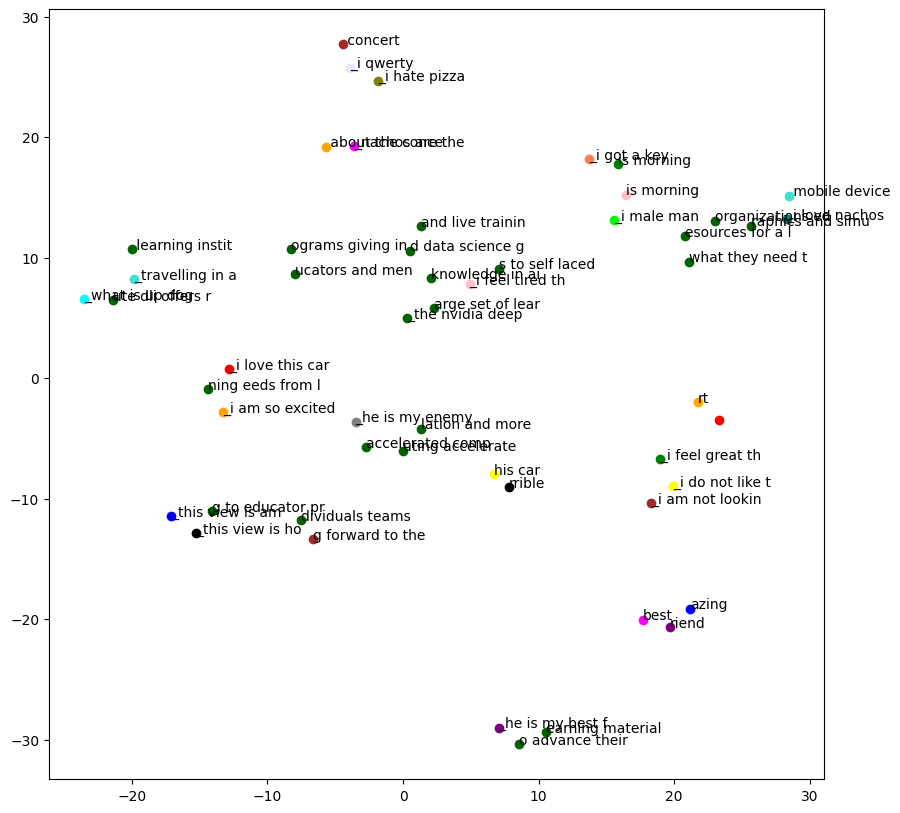

In [177]:
plt.figure(figsize=(10,10))
colors = ['red', 'blue', 'green', 'orange', 'purple', 'yellow', 'black', 'pink', 'brown', 'grey', 'cyan', 'magenta', 'olive', 'teal', 'coral', 'lime', 'lavender', 'turquoise', 'darkgreen', 'tan', 'salmon', 'gold', 'darkred', 'darkblue']
for i, item in enumerate(proj):
    
    plt.scatter(item[:,0], item[:,1], label=f'sentence {i}', c=colors[i])

for i, sentence in enumerate(s):
    for j, word in enumerate(sentence):
        plt.annotate(word, (proj[i][j,0], proj[i][j,1]), fontsize=10)   
#plt.legend()
plt.show()


In [25]:
a = '_'+s
# split char
ids = 16
a = [a[i:i+ids] for i in range(0, len(a), ids)]
proj = outputs['x_outs'][3][0].squeeze(0).detach().cpu().numpy()
print(proj.shape, len(a))
# umap force it to be spread out
proj = umap.UMAP(n_components=2, metric='cosine', random_state=42, n_neighbors=3, spread=2.5, min_dist=1.5).fit_transform(proj)

[NeMo W 2023-04-22 12:25:02 nemo_logging:349] /store/store1/software/bin/anaconda3/envs/k2_custom-nemo/lib/python3.8/site-packages/umap/umap_.py:1356: RuntimeWarning: divide by zero encountered in power
      return 1.0 / (1.0 + a * x ** (2 * b))
    


(23, 512) 23


In [28]:
import matplotlib.pyplot as plt

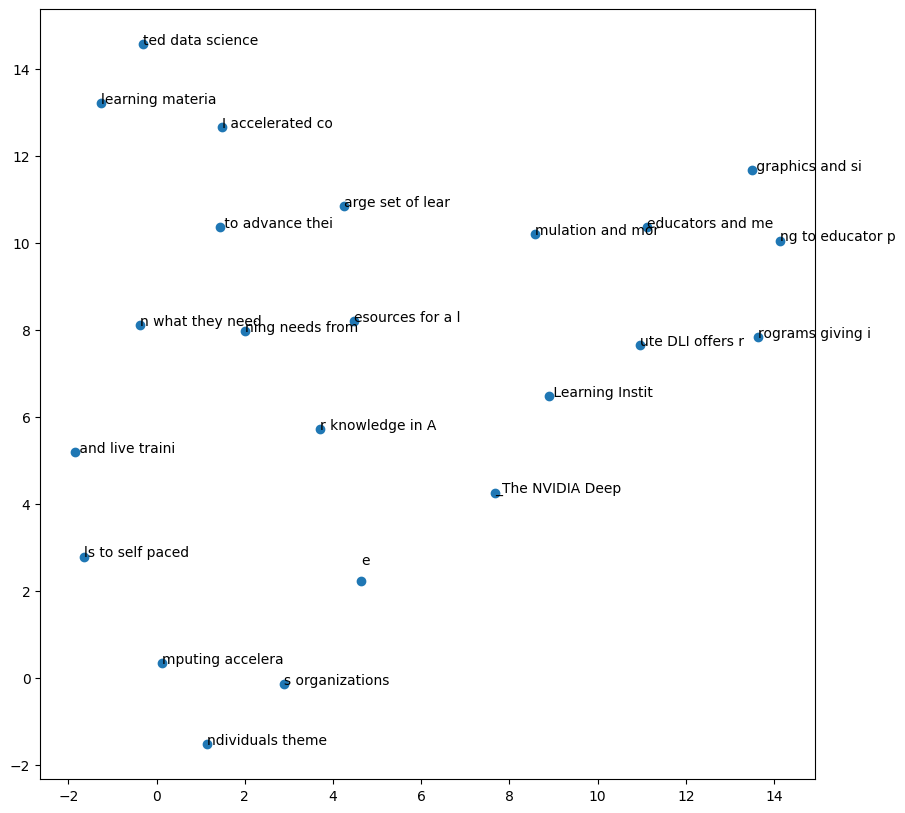

In [27]:
plt.figure(figsize=(10,10))
plt.scatter(proj[:,0], proj[:,1])
#plt.scatter(prok2[:,0], prok2[:,1], c='r')
# add labels (a)
import random
for i, txt in enumerate(a):
    st = f'{txt}'
    if random.random() < 0.9999:
        plt.annotate(st, (proj[i,0], proj[i,1]), size=10)
        #plt.annotate(st, (prok2[i,0], prok2[i,1]), size=10, c='r')
plt.show()

In [192]:
for ix in range(1,5):
    items = ["_".join(str(el) for el in it.tolist()) for it in outputs['targets'][ix][0]]
    num_items = len(items)
    unique_items = list(set(items))
    num_unique_items = len(unique_items)
    print(f'num_items: {num_items}, num_unique_items: {num_unique_items} ratio: {num_unique_items/num_items}, ix: {ix}')

num_items: 22, num_unique_items: 3 ratio: 0.13636363636363635, ix: 1


╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ /tmp/ipykernel_2286230/2147051343.py:2 in <module>                                               │
│                                                                                                  │
│ [Errno 2] No such file or directory: '/tmp/ipykernel_2286230/2147051343.py'                      │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
IndexError: list index out of range

In [ ]:
for ix in range(1,5):
    items = ["_".join(str(el) for el in it.tolist()) for it in outputs['targets'][ix][0]]
    num_items = len(items)
    unique_items = list(set(items))
    num_unique_items = len(unique_items)
    print(f'num_items: {num_items}, num_unique_items: {num_unique_items} ratio: {num_unique_items/num_items}, ix: {ix}')

In [191]:
for t in outputs['targets'][1:]:
    tog = t + (torch.arange(t.shape[-1]) * 12)[None,None,:]
    tog = rearrange(tog, 'b n h -> (b n h)')
    alltog = torch.unique(tog)
    percent = (alltog.shape[0] / (12 * t.shape[-1]) ) * 100
    print(f'percent: {percent}')

percent: 41.66666666666667


In [172]:
for t in outputs['targets'][1:]:
    tog = t + (torch.arange(t.shape[-1]) * 12)[None,None,:]
    tog = rearrange(tog, 'b n h -> (b n h)')
    alltog = torch.unique(tog)
    percent = (alltog.shape[0] / (12 * t.shape[-1]) ) * 100
    print(f'percent: {percent}')

percent: 54.947916666666664


In [204]:
outputs['targets'][-1][0][:10, 20:]

tensor([[ 3,  0,  2, 10,  7,  2,  0,  9,  2,  5,  7,  6],
        [ 1,  7,  9,  6, 10,  7,  5,  0,  8,  3,  2,  3],
        [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0]])

In [99]:
sentences = [
    'I love this car',
    'This view is amazing',
    'I feel great this morning',
    'I am so excited about the concert',
    'He is my best friend',
    'I do not like this car',
    'This view is horrible',
    'I feel tired this morning',
    'I am not looking forward to the concert',
    'He is my enemy'
]
sentences = [s.lower() for s in sentences]
x = [[0] + tokenizer.text_to_ids(s) for s in sentences] # add bos token
lengths = [len(s) for s in x]
max_len = max(lengths)
x = [s + [0] * (max_len - len(s)) for s in x] # pad
x = torch.tensor(x)
lengths = torch.tensor(lengths)
tlm.eval()
with torch.no_grad():
    outputs = tlm(x, lengths, calc_loss=True)

In [ ]:
s = """The NVIDIA Deep Learning Institute DLI offers resources for a large set of learning needs from learning materials to self paced and live training to educator programs giving individuals teams organizations educators and men what they need to advance their knowledge in AI accelerated computing accelerated data science graphics and simulation and more
"""
x = tokenizer.text_to_ids(s.lower())
x = [0] + x 
x = torch.tensor(x).unsqueeze(0)
tlm.eval()
x = repeat(x, '1 n -> b n', b=2)
length = torch.tensor([len(x[0]), len(x[0])])
#cache = None
with torch.no_grad():
    outputs = tlm(x, length, calc_loss=True)#, cache=outputs['cache'])

In [206]:
print(outputs['token_losses'])

tensor([22.1017])


In [209]:
print(outputs['token_losses'])

tensor([22.1092])


In [173]:
!ls ./checkpoints/unitformer_test/checkpoint_0_id_50.pt
checkpoint = torch.load('../checkpoints/unitformer_test/checkpoint_1_id_29.pt', map_location='cpu')
tlm.load_state_dict(checkpoint['model_state_dict'])

ls: cannot access './checkpoints/unitformer_test/checkpoint_0_id_50.pt': No such file or directory


<All keys matched successfully>

In [15]:
!ls ./lm/tokenizers/tokenizer_spe_bpe_v29/tokenizer.model

ls: cannot access './lm/tokenizers/tokenizer_spe_bpe_v29/tokenizer.model': No such file or directory


In [6]:
tokenizer = tools.load_tokenizer('../lm/tokenizers/tokenizer_spe_bpe_v29/tokenizer.model')

In [19]:
x = tokenizer.text_to_ids("""so today I went to the park""".lower())
x = torch.tensor(x).unsqueeze(0)
length = torch.tensor([len(x[0])])
cache = None
outputs = tlm(x, length, calc_loss=True)#,cache=cache, calc_loss=False)

In [71]:
outputs['targets']

[tensor([[ 1, 16, 15,  1,  7,  4, 16,  2,  1, 25,  2, 19, 19]]),
 tensor([[ 43,  23, 112,  97,  61, 172, 158]]),
 tensor([[ 2, 81,  6, 47]]),
 tensor([[1, 2]])]

In [239]:
"""Convolution operations and higher order neural networks From the perspective of modern
deep learning considering higher order correlations between downstream inputs to a neuron is
quite classical"""

'Convolution operations and higher order neural networks From the perspective of modern\ndeep learning considering higher order correlations between downstream inputs to a neuron is\nquite classical'

In [413]:
outputs['targets']

[tensor([[ 1, 17,  9,  4,  3,  1,  3,  6, 16,  2,  1,  6,  8,  1,  6,  3,  1,  5,
           9,  1,  7,  5,  1, 21, 11,  4,  9,  1, 21, 11,  4,  9,  1, 27, 27,  1,
           6,  1, 11,  6, 23,  2,  1, 14,  4, 10, 10,  5,  3,  8]]),
 tensor([[ 30,  37, 124,  45, 119, 118, 105,  95,  62,   7,  99, 160, 137,   7,
            0, 100,  62, 110, 124,  74, 119, 134,  89,  99, 182]]),
 tensor([[260, 254,  35, 254, 314, 384,  35, 254,  27, 254,  35, 172, 390]]),
 tensor([[357, 140, 140, 140, 140, 140, 689]])]

In [94]:
labels = torch.randint(0, 29, (3, 25))
length = torch.tensor([6, 1, 25])
tlm_out = tlm(labels, length, calc_loss=True, cache=tlm_out['cache'])

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ /tmp/ipykernel_2637/3567845408.py:3 in <module>                                                  │
│                                                                                                  │
│ [Errno 2] No such file or directory: '/tmp/ipykernel_2637/3567845408.py'                         │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
NameError: name 'tlm_out' is not defined

In [424]:
tlm_out['targets']

[tensor([[ 3,  4, 13, 15, 21, 10, 17, 25, 14, 20, 16,  3,  7, 19,  3,  8,  7, 13,
          24,  6, 10, 25, 22,  4, 24],
         [26,  2, 19,  6, 10,  9, 27, 21, 24,  3, 21, 23, 13, 27, 13, 19, 12,  4,
          18, 16, 21, 25, 14, 25, 10],
         [14,  1, 20, 15, 28, 26, 28, 23, 23, 28, 19,  7, 23,  9,  4, 10, 22, 24,
          25, 21, 16, 22, 27, 28, 16]]),
 tensor([[137,  89,   0, 102, 152,  95, 145, 182, 146,  45, 174,  11, 164],
         [119, 117, 100, 119,  95,   0, 169, 168, 106,  61,   0, 152, 174],
         [  7, 104, 169, 152, 163,  56, 100,  89, 163,  22,   8, 134,  43]]),
 tensor([[448, 228,  96,  50, 139, 461, 391],
         [156, 461, 448, 301, 156, 448, 390],
         [156,  50, 466, 448, 138,  48, 391]]),
 tensor([[427, 309, 426, 494],
         [494,  96, 426, 742],
         [665, 328, 328, 494]])]

In [191]:
torch.cat([torch.tensor([0.]),tlm_out['token_losses']])

tensor([ 0.0000,  3.3361,  9.0943, 11.7116, 12.9673], grad_fn=<CatBackward0>)

In [132]:
tlm_out['cache'][0]['layer_below_next_sentence_pred'].shape

torch.Size([3, 2, 29])

In [138]:
[el.shape for el in tlm_out['layer_below_predictions'] if el is not None]

[torch.Size([3, 10, 29]), torch.Size([3, 5, 186]), torch.Size([3, 3, 471])]

tensor([[[ 0.5522,  0.7073, -0.4004, -1.7506, -0.3139, -0.3931, -0.5387,
          -0.3880,  0.9586, -0.7569,  0.3536, -0.6996, -0.7060,  1.7352,
          -1.5477,  1.5172,  1.1682,  0.7225,  0.0731,  2.8862, -0.4295,
           0.3552,  0.9085, -0.1108, -0.2837, -0.1412,  0.2152, -0.3472,
           3.5744]],

        [[-0.8612, -0.3983,  0.2439, -0.0434, -0.0573,  0.2012,  0.0373,
           0.5064, -1.8880, -1.3106, -0.3143, -0.5900, -1.3373, -0.6801,
          -1.1815, -1.3725, -0.5302,  0.2932,  1.1263, -2.9227, -1.2165,
          -0.3096,  0.0746,  2.1863, -0.7000, -2.6588,  0.9164,  0.5734,
          -0.8377]],

        [[-0.5840,  1.0222, -0.4094,  1.4468,  0.3316,  0.2704, -0.3063,
           0.6731,  0.0478,  1.6772,  0.4766,  0.7292, -1.9728, -0.5385,
           0.5501, -0.0900, -0.6048,  0.3224, -0.5616, -1.0638,  0.7505,
          -0.3843,  0.1069,  0.4991,  1.2616,  0.1580, -0.1634,  0.4385,
           1.0510]]], grad_fn=<SliceBackward0>)

In [6]:
import matplotlib.pyplot as plt

In [7]:
idx = torch.stack([length-2,length-1], dim=1)[...,None].expand(-1,-1,29)

torch.Size([32, 12, 16])
torch.Size([384, 384])


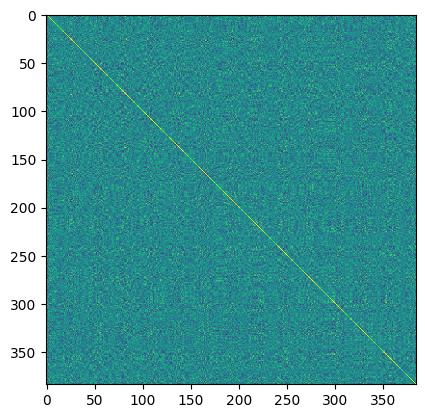

In [148]:
codebook = tlm.layers.vq.codebook
# l2 norm of codebook
codebook_norm = codebook / codebook.norm(dim=-1, keepdim=True)
# lets plot the similarity matrix
print(codebook_norm.shape)
#similarity = einsumops(codebook_norm, codebook_norm, 'h v d, h j d -> h v j')
#similarity = rearrange(similarity, 'h v j -> (h v) j')
codebook_norm = rearrange(codebook_norm, 'h v d -> (h v) d')
similarity = (codebook_norm @ codebook_norm.T)
print(similarity.shape)
# lets plot the similarity matrix
plt.imshow(similarity.detach().cpu().numpy())

torch.Size([32, 12, 16])
torch.Size([384, 384])


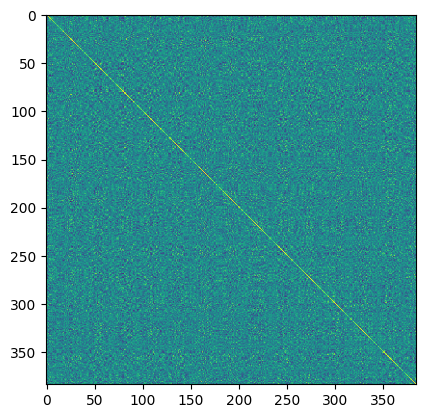

In [174]:
codebook = tlm.layers.vq.codebook
# l2 norm of codebook
codebook_norm = codebook / codebook.norm(dim=-1, keepdim=True)
# lets plot the similarity matrix
print(codebook_norm.shape)
#similarity = einsumops(codebook_norm, codebook_norm, 'h v d, h j d -> h v j')
#similarity = rearrange(similarity, 'h v j -> (h v) j')
codebook_norm = rearrange(codebook_norm, 'h v d -> (h v) d')
similarity = (codebook_norm @ codebook_norm.T)
print(similarity.shape)
# lets plot the similarity matrix
plt.imshow(similarity.detach().cpu().numpy())